In [1]:
import pydub
import pandas as pd
import librosa as lb
import numpy as np
import os
from linetimer import CodeTimer

In [2]:
def osPath(path):
    return os.path.abspath(path)

In [3]:
pathname = "Datasets/validated.tsv"
output_pathname = "Datasets/validated_SpeechFeatures.tsv"

In [4]:
mp3_folder = "Datasets/clips/" # Location of mp3 audio files
wav_folder = "Datasets/wav_clips/" # Location where wav files will be saved
os.environ["PATH"] += os.pathsep + 'FFMPEG/bin' # Path to FFMPEG bin

# Feature Extraction

In [ ]:
i_limit = 10000
i = 0
dir = os.fsdecode(mp3_folder)
for path in os.listdir(dir):
    if i == i_limit:
        break
    src = os.path.join(dir, path)
    dst = wav_folder + path[:-3] + str("wav")
    sound = pydub.AudioSegment.from_mp3(src)
    sound.export(dst, format("wav"))
    i += 1

In [5]:
df = pd.read_csv(pathname, sep="\t")
df

,client_id,path,sentence,up_votes,down_votes,age,gender,accent
0,0013037a1d45cc33460806cc3f8ecee9d536c45639ba4c...,common_voice_en_699711.mp3,She'll be all right.,2,1,NaN,NaN,NaN
1,003fb666a99eb3aa3ba05d9c8641c18e55cf7d34d1b981...,common_voice_en_17263741.mp3,Do you mean it?,2,0,NaN,NaN,NaN
2,0047f1aea3f39c4c6a9298d84f046c1f84f439f594d840...,common_voice_en_17561821.mp3,How is Mozilla going to handle ambiguities lik...,2,0,NaN,NaN,NaN
3,00610bda27826b8615139e6a430d43382935f37922dc1c...,common_voice_en_59751.mp3,I guess you must think I'm kinda batty.,2,1,NaN,NaN,NaN
4,007762ba618b38ed77739616c7a6ace0341e1e134ac405...,common_voice_en_18902772.mp3,Groves started writing songs when she was four...,2,1,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
644114,939991dfcf12d8250739f3b4e5ed47e0dc4bf8ffb69810...,common_voice_en_18792608.mp3,It is almost exclusively in the final version ...,2,1,twenties,male,NaN
644115,939991dfcf12d8250739f3b4e5ed47e0dc4bf8ffb69810...,common_voice_en_18792609.mp3,All songs written by Mark Greaney.,2,0,twenties,male,NaN
644116,939991dfcf12d8250739f3b4e5ed47e0dc4bf8ffb69810...,common_voice_en_18792611.mp3,Later the ninth and tenth grades were added.,2,1,twenties,male,NaN
644117,939991dfcf12d8250739f3b4e5ed47e0dc4bf8ffb69810...,common_voice_en_18792612.mp3,"Aull, who named it Quasi-Rolle theorem.",2,1,twenties,male,NaN


In [6]:
df = df.dropna(subset=["age","gender","accent"]) # This will DEFINITELY lead to a smaller sample size and less reliable results, but for simplicity's and comparison's sake, let's only go with the data that also includes accents and ages.

# df = df[df.gender != "other"] # Let's not remove these right away. We can run an experiment on whether models are affected by this or not.

df = df[["up_votes","down_votes","path", "age", "gender","accent"]] # Might be a good idea to keep up_votes nad down_votes as well, so I added these.

df

,up_votes,down_votes,path,age,gender,accent
8,2,0,common_voice_en_18489793.mp3,thirties,male,us
11,2,0,common_voice_en_17779714.mp3,thirties,male,canada
40,2,1,common_voice_en_125399.mp3,seventies,female,england
44,2,1,common_voice_en_18274221.mp3,twenties,male,us
54,2,0,common_voice_en_17147389.mp3,twenties,male,us
...,...,...,...,...,...,...
638031,2,0,common_voice_en_18829416.mp3,sixties,male,us
638032,2,0,common_voice_en_18829417.mp3,sixties,male,us
638033,2,0,common_voice_en_18829418.mp3,sixties,male,us
638034,2,0,common_voice_en_18829419.mp3,sixties,male,us


In [7]:
# New Columns
column_chroma_stft = [] #chromagram https://en.wikipedia.org/wiki/Chroma_feature
column_rms = [] #root mean square https://en.wikipedia.org/wiki/Root_mean_square#In_common_waveforms
column_spec_cent = [] #spectral centroid https://en.wikipedia.org/wiki/Spectral_centroid
column_spec_bw = [] #spectral bandwidth https://en.wikipedia.org/wiki/Bandwidth_(signal_processing)#x_dB_bandwidth
column_rolloff = [] #spectral roll-off https://en.wikipedia.org/wiki/Roll-off
column_zcr = [] #zero-crossing rate https://en.wikipedia.org/wiki/Zero-crossing_rate
column_mfcc = [] #Mel-frequency cepstrum coefficients https://en.wikipedia.org/wiki/Mel-frequency_cepstrum

In [8]:
# Get all audio file paths and names
wav_FilePaths = []
mp3_FileNames = []
dir = os.fsdecode(wav_folder)
for path in os.listdir(dir):
    src = os.path.join(dir, path)
    name = path[:-3] + str("mp3")
    wav_FilePaths.append(src)
    mp3_FileNames.append(name)

In [9]:
# Remove all entries from dataframe where we don't have the given audio file
df = df[df["path"].isin(mp3_FileNames)]
dictionary = dict(zip(mp3_FileNames, wav_FilePaths))
df["path"] = df["path"].map(dictionary)

C:\Users\Frederik\Anaconda3\envs\Py3_IDS\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [10]:
df

,up_votes,down_votes,path,age,gender,accent
2252,2,0,Datasets/wav_clips/common_voice_en_10091129.wav,fifties,male,us
2253,2,0,Datasets/wav_clips/common_voice_en_10091130.wav,fifties,male,us
3550,4,0,Datasets/wav_clips/common_voice_en_10563.wav,thirties,other,us
3551,4,0,Datasets/wav_clips/common_voice_en_10564.wav,thirties,other,us
3770,2,0,Datasets/wav_clips/common_voice_en_10410522.wav,twenties,male,us
...,...,...,...,...,...,...
577481,2,0,Datasets/wav_clips/common_voice_en_10209062.wav,fifties,female,us
577482,2,0,Datasets/wav_clips/common_voice_en_10209063.wav,fifties,female,us
577483,2,0,Datasets/wav_clips/common_voice_en_10209065.wav,fifties,female,us
577484,2,0,Datasets/wav_clips/common_voice_en_10209066.wav,fifties,female,us


In [11]:
# Get speech features, add them to the dataframe and export to csv file
for index, row in df.iterrows():
        with CodeTimer('Loading'):
            y, sr = lb.load(osPath(row.path))
        
            chroma_stft = np.mean(lb.feature.chroma_stft(y=y, sr=sr))
            #https://librosa.github.io/librosa/generated/librosa.feature.chroma_stft.html
            rms = np.mean(lb.feature.rms(y=y))
            #https://librosa.github.io/librosa/generated/librosa.feature.rms.html
            spec_cent = np.mean(lb.feature.spectral_centroid(y=y, sr=sr))
            #https://librosa.github.io/librosa/generated/librosa.feature.spectral_centroid.html
            spec_bw = np.mean(lb.feature.spectral_bandwidth(y=y, sr=sr))
            #https://librosa.github.io/librosa/generated/librosa.feature.spectral_bandwidth.html
            rolloff = np.mean(lb.feature.spectral_rolloff(y=y, sr=sr))
            #https://librosa.github.io/librosa/generated/librosa.feature.spectral_rolloff.html
            zcr = np.mean(lb.feature.zero_crossing_rate(y))
            #https://librosa.github.io/librosa/generated/librosa.feature.zero_crossing_rate.html
            mfcc = np.mean(lb.feature.mfcc(y=y, sr=sr))
            #https://librosa.github.io/librosa/generated/librosa.feature.mfcc.html

            column_chroma_stft.append(chroma_stft)
            column_rms.append(rms)
            column_spec_cent.append(spec_cent)
            column_spec_bw.append(spec_bw)
            column_rolloff.append(rolloff)
            column_zcr.append(zcr)
            column_mfcc.append(mfcc)

Code block 'Loading' took: 627.24930 ms
Code block 'chroma_stft' took: 15.16510 ms
Code block 'rms' took: 2.05050 ms
Code block 'spec_cent' took: 7.77520 ms
Code block 'spec_bw' took: 13.02660 ms
Code block 'rolloff' took: 6.35190 ms
Code block 'zcr' took: 3.85320 ms
Code block 'mfcc' took: 7.89240 ms
Code block 'appending' took: 0.00320 ms
Code block 'Loading' took: 173.31680 ms
Code block 'chroma_stft' took: 13.87980 ms
Code block 'rms' took: 1.96020 ms
Code block 'spec_cent' took: 7.43930 ms
Code block 'spec_bw' took: 12.51690 ms
Code block 'rolloff' took: 5.94940 ms
Code block 'zcr' took: 3.80840 ms
Code block 'mfcc' took: 6.67850 ms
Code block 'appending' took: 0.00290 ms
Code block 'Loading' took: 309.11440 ms
Code block 'chroma_stft' took: 32.42010 ms
Code block 'rms' took: 3.25680 ms
Code block 'spec_cent' took: 18.33980 ms
Code block 'spec_bw' took: 26.06220 ms
Code block 'rolloff' took: 12.53780 ms
Code block 'zcr' took: 7.57200 ms
Code block 'mfcc' took: 11.56140 ms
Code blo

Code block 'Loading' took: 181.89130 ms
Code block 'chroma_stft' took: 14.92280 ms
Code block 'rms' took: 1.99310 ms
Code block 'spec_cent' took: 8.10820 ms
Code block 'spec_bw' took: 13.37000 ms
Code block 'rolloff' took: 6.39070 ms
Code block 'zcr' took: 3.90220 ms
Code block 'mfcc' took: 7.79820 ms
Code block 'appending' took: 0.00300 ms
Code block 'Loading' took: 79.67530 ms
Code block 'chroma_stft' took: 6.43750 ms
Code block 'rms' took: 0.70130 ms
Code block 'spec_cent' took: 2.26760 ms
Code block 'spec_bw' took: 3.38180 ms
Code block 'rolloff' took: 2.91610 ms
Code block 'zcr' took: 1.33400 ms
Code block 'mfcc' took: 4.63610 ms
Code block 'appending' took: 0.00450 ms
Code block 'Loading' took: 105.11190 ms
Code block 'chroma_stft' took: 8.21120 ms
Code block 'rms' took: 1.21870 ms
Code block 'spec_cent' took: 4.28700 ms
Code block 'spec_bw' took: 8.16780 ms
Code block 'rolloff' took: 3.86700 ms
Code block 'zcr' took: 2.02290 ms
Code block 'mfcc' took: 4.89050 ms
Code block 'appe

Code block 'Loading' took: 185.67090 ms
Code block 'chroma_stft' took: 14.82860 ms
Code block 'rms' took: 2.06520 ms
Code block 'spec_cent' took: 7.81610 ms
Code block 'spec_bw' took: 13.08710 ms
Code block 'rolloff' took: 6.29900 ms
Code block 'zcr' took: 3.78480 ms
Code block 'mfcc' took: 6.73460 ms
Code block 'appending' took: 0.00340 ms
Code block 'Loading' took: 136.80380 ms
Code block 'chroma_stft' took: 11.98330 ms
Code block 'rms' took: 1.45290 ms
Code block 'spec_cent' took: 5.86750 ms
Code block 'spec_bw' took: 10.50770 ms
Code block 'rolloff' took: 5.00310 ms
Code block 'zcr' took: 3.19460 ms
Code block 'mfcc' took: 5.66290 ms
Code block 'appending' took: 0.00300 ms
Code block 'Loading' took: 120.68130 ms
Code block 'chroma_stft' took: 9.35920 ms
Code block 'rms' took: 1.62800 ms
Code block 'spec_cent' took: 5.38970 ms
Code block 'spec_bw' took: 9.77940 ms
Code block 'rolloff' took: 4.32490 ms
Code block 'zcr' took: 2.50130 ms
Code block 'mfcc' took: 6.37690 ms
Code block 'a

Code block 'Loading' took: 155.39360 ms
Code block 'chroma_stft' took: 12.13740 ms
Code block 'rms' took: 1.95210 ms
Code block 'spec_cent' took: 7.06680 ms
Code block 'spec_bw' took: 11.36530 ms
Code block 'rolloff' took: 5.53330 ms
Code block 'zcr' took: 3.09500 ms
Code block 'mfcc' took: 6.21330 ms
Code block 'appending' took: 0.00690 ms
Code block 'Loading' took: 114.61620 ms
Code block 'chroma_stft' took: 8.68710 ms
Code block 'rms' took: 1.38510 ms
Code block 'spec_cent' took: 4.86160 ms
Code block 'spec_bw' took: 10.28830 ms
Code block 'rolloff' took: 4.40350 ms
Code block 'zcr' took: 2.34390 ms
Code block 'mfcc' took: 5.17470 ms
Code block 'appending' took: 0.00310 ms
Code block 'Loading' took: 238.87780 ms
Code block 'chroma_stft' took: 23.10690 ms
Code block 'rms' took: 2.14690 ms
Code block 'spec_cent' took: 11.02530 ms
Code block 'spec_bw' took: 19.73530 ms
Code block 'rolloff' took: 9.25230 ms
Code block 'zcr' took: 5.98360 ms
Code block 'mfcc' took: 10.31000 ms
Code block

Code block 'Loading' took: 253.00470 ms
Code block 'chroma_stft' took: 24.46780 ms
Code block 'rms' took: 2.22770 ms
Code block 'spec_cent' took: 11.60480 ms
Code block 'spec_bw' took: 20.88690 ms
Code block 'rolloff' took: 9.86610 ms
Code block 'zcr' took: 6.03240 ms
Code block 'mfcc' took: 11.17590 ms
Code block 'appending' took: 0.00320 ms
Code block 'Loading' took: 119.34320 ms
Code block 'chroma_stft' took: 9.32780 ms
Code block 'rms' took: 1.45620 ms
Code block 'spec_cent' took: 5.40710 ms
Code block 'spec_bw' took: 8.65510 ms
Code block 'rolloff' took: 4.21400 ms
Code block 'zcr' took: 2.42630 ms
Code block 'mfcc' took: 6.25700 ms
Code block 'appending' took: 0.00340 ms
Code block 'Loading' took: 133.37640 ms
Code block 'chroma_stft' took: 10.08410 ms
Code block 'rms' took: 1.77120 ms
Code block 'spec_cent' took: 6.28960 ms
Code block 'spec_bw' took: 10.23340 ms
Code block 'rolloff' took: 4.70810 ms
Code block 'zcr' took: 2.85030 ms
Code block 'mfcc' took: 5.79930 ms
Code block 

Code block 'Loading' took: 138.54250 ms
Code block 'chroma_stft' took: 10.47460 ms
Code block 'rms' took: 1.74980 ms
Code block 'spec_cent' took: 6.40990 ms
Code block 'spec_bw' took: 10.64370 ms
Code block 'rolloff' took: 5.49620 ms
Code block 'zcr' took: 2.68370 ms
Code block 'mfcc' took: 6.70330 ms
Code block 'appending' took: 0.00370 ms
Code block 'Loading' took: 158.09350 ms
Code block 'chroma_stft' took: 12.58800 ms
Code block 'rms' took: 1.64660 ms
Code block 'spec_cent' took: 6.92830 ms
Code block 'spec_bw' took: 12.20530 ms
Code block 'rolloff' took: 5.58210 ms
Code block 'zcr' took: 3.32690 ms
Code block 'mfcc' took: 6.11640 ms
Code block 'appending' took: 0.00340 ms
Code block 'Loading' took: 197.24100 ms
Code block 'chroma_stft' took: 16.57160 ms
Code block 'rms' took: 2.31710 ms
Code block 'spec_cent' took: 8.66680 ms
Code block 'spec_bw' took: 14.24100 ms
Code block 'rolloff' took: 7.15990 ms
Code block 'zcr' took: 4.68010 ms
Code block 'mfcc' took: 7.89520 ms
Code block 

Code block 'Loading' took: 199.20160 ms
Code block 'chroma_stft' took: 21.41810 ms
Code block 'rms' took: 1.95280 ms
Code block 'spec_cent' took: 9.48230 ms
Code block 'spec_bw' took: 16.40340 ms
Code block 'rolloff' took: 8.36370 ms
Code block 'zcr' took: 4.62360 ms
Code block 'mfcc' took: 9.77760 ms
Code block 'appending' took: 0.00330 ms
Code block 'Loading' took: 146.28710 ms
Code block 'chroma_stft' took: 11.17960 ms
Code block 'rms' took: 1.85780 ms
Code block 'spec_cent' took: 6.20080 ms
Code block 'spec_bw' took: 10.56620 ms
Code block 'rolloff' took: 5.14270 ms
Code block 'zcr' took: 3.15840 ms
Code block 'mfcc' took: 5.83980 ms
Code block 'appending' took: 0.00310 ms
Code block 'Loading' took: 320.54500 ms
Code block 'chroma_stft' took: 31.69260 ms
Code block 'rms' took: 2.95380 ms
Code block 'spec_cent' took: 14.51370 ms
Code block 'spec_bw' took: 25.88810 ms
Code block 'rolloff' took: 12.95720 ms
Code block 'zcr' took: 7.99250 ms
Code block 'mfcc' took: 11.24230 ms
Code blo

Code block 'Loading' took: 165.51880 ms
Code block 'chroma_stft' took: 12.51180 ms
Code block 'rms' took: 2.07560 ms
Code block 'spec_cent' took: 6.87660 ms
Code block 'spec_bw' took: 14.37000 ms
Code block 'rolloff' took: 5.76950 ms
Code block 'zcr' took: 4.11200 ms
Code block 'mfcc' took: 7.44200 ms
Code block 'appending' took: 0.00350 ms
Code block 'Loading' took: 189.79320 ms
Code block 'chroma_stft' took: 15.48440 ms
Code block 'rms' took: 2.17120 ms
Code block 'spec_cent' took: 8.30930 ms
Code block 'spec_bw' took: 15.14880 ms
Code block 'rolloff' took: 7.95520 ms
Code block 'zcr' took: 4.76740 ms
Code block 'mfcc' took: 7.49210 ms
Code block 'appending' took: 0.00320 ms
Code block 'Loading' took: 195.46770 ms
Code block 'chroma_stft' took: 19.72750 ms
Code block 'rms' took: 1.76980 ms
Code block 'spec_cent' took: 9.02950 ms
Code block 'spec_bw' took: 16.24370 ms
Code block 'rolloff' took: 7.98450 ms
Code block 'zcr' took: 4.98940 ms
Code block 'mfcc' took: 8.59240 ms
Code block 

Code block 'Loading' took: 155.93200 ms
Code block 'chroma_stft' took: 13.06170 ms
Code block 'rms' took: 1.71970 ms
Code block 'spec_cent' took: 6.94380 ms
Code block 'spec_bw' took: 11.38240 ms
Code block 'rolloff' took: 5.45930 ms
Code block 'zcr' took: 3.50260 ms
Code block 'mfcc' took: 6.06420 ms
Code block 'appending' took: 0.00330 ms
Code block 'Loading' took: 163.14670 ms
Code block 'chroma_stft' took: 13.34440 ms
Code block 'rms' took: 2.60790 ms
Code block 'spec_cent' took: 9.50090 ms
Code block 'spec_bw' took: 12.07570 ms
Code block 'rolloff' took: 5.55080 ms
Code block 'zcr' took: 3.88470 ms
Code block 'mfcc' took: 6.31670 ms
Code block 'appending' took: 0.00370 ms
Code block 'Loading' took: 165.91120 ms
Code block 'chroma_stft' took: 12.31260 ms
Code block 'rms' took: 2.05880 ms
Code block 'spec_cent' took: 6.83660 ms
Code block 'spec_bw' took: 12.12150 ms
Code block 'rolloff' took: 5.97650 ms
Code block 'zcr' took: 3.49270 ms
Code block 'mfcc' took: 7.41780 ms
Code block 

Code block 'chroma_stft' took: 35.30380 ms
Code block 'rms' took: 1.78970 ms
Code block 'spec_cent' took: 11.87580 ms
Code block 'spec_bw' took: 12.62220 ms
Code block 'rolloff' took: 4.89280 ms
Code block 'zcr' took: 2.74120 ms
Code block 'mfcc' took: 5.60550 ms
Code block 'appending' took: 0.00300 ms
Code block 'Loading' took: 154.80100 ms
Code block 'chroma_stft' took: 16.47270 ms
Code block 'rms' took: 2.27210 ms
Code block 'spec_cent' took: 7.26990 ms
Code block 'spec_bw' took: 12.36390 ms
Code block 'rolloff' took: 5.57070 ms
Code block 'zcr' took: 3.37080 ms
Code block 'mfcc' took: 6.89570 ms
Code block 'appending' took: 0.00300 ms
Code block 'Loading' took: 128.41940 ms
Code block 'chroma_stft' took: 11.25750 ms
Code block 'rms' took: 1.48060 ms
Code block 'spec_cent' took: 6.26540 ms
Code block 'spec_bw' took: 13.26970 ms
Code block 'rolloff' took: 5.48090 ms
Code block 'zcr' took: 3.02090 ms
Code block 'mfcc' took: 6.88870 ms
Code block 'appending' took: 0.00290 ms
Code block

Code block 'Loading' took: 87.11130 ms
Code block 'chroma_stft' took: 7.33760 ms
Code block 'rms' took: 1.05770 ms
Code block 'spec_cent' took: 2.93790 ms
Code block 'spec_bw' took: 4.02340 ms
Code block 'rolloff' took: 3.49990 ms
Code block 'zcr' took: 1.29450 ms
Code block 'mfcc' took: 4.68410 ms
Code block 'appending' took: 0.00290 ms
Code block 'Loading' took: 55.17120 ms
Code block 'chroma_stft' took: 4.99500 ms
Code block 'rms' took: 0.70260 ms
Code block 'spec_cent' took: 1.78430 ms
Code block 'spec_bw' took: 2.22130 ms
Code block 'rolloff' took: 1.61970 ms
Code block 'zcr' took: 0.85360 ms
Code block 'mfcc' took: 3.65040 ms
Code block 'appending' took: 0.00290 ms
Code block 'Loading' took: 125.67620 ms
Code block 'chroma_stft' took: 9.77970 ms
Code block 'rms' took: 1.63300 ms
Code block 'spec_cent' took: 5.56930 ms
Code block 'spec_bw' took: 9.80160 ms
Code block 'rolloff' took: 4.52070 ms
Code block 'zcr' took: 2.56810 ms
Code block 'mfcc' took: 5.33410 ms
Code block 'appendi

Code block 'mfcc' took: 16.25420 ms
Code block 'appending' took: 0.00330 ms
Code block 'Loading' took: 131.90300 ms
Code block 'chroma_stft' took: 9.59320 ms
Code block 'rms' took: 1.43780 ms
Code block 'spec_cent' took: 5.55400 ms
Code block 'spec_bw' took: 9.57250 ms
Code block 'rolloff' took: 4.51330 ms
Code block 'zcr' took: 2.71700 ms
Code block 'mfcc' took: 5.31790 ms
Code block 'appending' took: 0.00300 ms
Code block 'Loading' took: 197.53130 ms
Code block 'chroma_stft' took: 20.33560 ms
Code block 'rms' took: 1.80200 ms
Code block 'spec_cent' took: 9.27930 ms
Code block 'spec_bw' took: 15.63570 ms
Code block 'rolloff' took: 7.64660 ms
Code block 'zcr' took: 4.36670 ms
Code block 'mfcc' took: 8.67680 ms
Code block 'appending' took: 0.00310 ms
Code block 'Loading' took: 131.92700 ms
Code block 'chroma_stft' took: 9.48540 ms
Code block 'rms' took: 1.77730 ms
Code block 'spec_cent' took: 5.97650 ms
Code block 'spec_bw' took: 10.51630 ms
Code block 'rolloff' took: 4.65030 ms
Code bl

Code block 'Loading' took: 135.63140 ms
Code block 'chroma_stft' took: 11.43880 ms
Code block 'rms' took: 1.54600 ms
Code block 'spec_cent' took: 5.86140 ms
Code block 'spec_bw' took: 10.29510 ms
Code block 'rolloff' took: 5.09350 ms
Code block 'zcr' took: 2.93880 ms
Code block 'mfcc' took: 5.99900 ms
Code block 'appending' took: 0.00310 ms
Code block 'Loading' took: 96.68300 ms
Code block 'chroma_stft' took: 7.39000 ms
Code block 'rms' took: 0.93270 ms
Code block 'spec_cent' took: 3.14010 ms
Code block 'spec_bw' took: 4.97850 ms
Code block 'rolloff' took: 4.04270 ms
Code block 'zcr' took: 2.15650 ms
Code block 'mfcc' took: 4.89090 ms
Code block 'appending' took: 0.00300 ms
Code block 'Loading' took: 190.36300 ms
Code block 'chroma_stft' took: 13.74180 ms
Code block 'rms' took: 2.25280 ms
Code block 'spec_cent' took: 7.91540 ms
Code block 'spec_bw' took: 14.05680 ms
Code block 'rolloff' took: 6.47720 ms
Code block 'zcr' took: 4.91850 ms
Code block 'mfcc' took: 7.89940 ms
Code block 'ap

Code block 'Loading' took: 146.74760 ms
Code block 'chroma_stft' took: 10.82260 ms
Code block 'rms' took: 1.62240 ms
Code block 'spec_cent' took: 6.35080 ms
Code block 'spec_bw' took: 10.64640 ms
Code block 'rolloff' took: 5.15800 ms
Code block 'zcr' took: 3.10730 ms
Code block 'mfcc' took: 6.04600 ms
Code block 'appending' took: 0.00330 ms
Code block 'Loading' took: 214.44640 ms
Code block 'chroma_stft' took: 20.23960 ms
Code block 'rms' took: 2.14000 ms
Code block 'spec_cent' took: 9.73050 ms
Code block 'spec_bw' took: 17.11260 ms
Code block 'rolloff' took: 7.90520 ms
Code block 'zcr' took: 4.74980 ms
Code block 'mfcc' took: 8.33910 ms
Code block 'appending' took: 0.00300 ms
Code block 'Loading' took: 177.94180 ms
Code block 'chroma_stft' took: 13.03580 ms
Code block 'rms' took: 2.05960 ms
Code block 'spec_cent' took: 7.59320 ms
Code block 'spec_bw' took: 12.90600 ms
Code block 'rolloff' took: 6.03920 ms
Code block 'zcr' took: 3.71050 ms
Code block 'mfcc' took: 6.70360 ms
Code block 

Code block 'rolloff' took: 4.16770 ms
Code block 'zcr' took: 2.56080 ms
Code block 'mfcc' took: 6.50640 ms
Code block 'appending' took: 0.00320 ms
Code block 'Loading' took: 163.38090 ms
Code block 'chroma_stft' took: 19.94560 ms
Code block 'rms' took: 2.15910 ms
Code block 'spec_cent' took: 8.41670 ms
Code block 'spec_bw' took: 12.12190 ms
Code block 'rolloff' took: 5.77150 ms
Code block 'zcr' took: 3.33550 ms
Code block 'mfcc' took: 7.35620 ms
Code block 'appending' took: 0.00330 ms
Code block 'Loading' took: 224.28000 ms
Code block 'chroma_stft' took: 21.06310 ms
Code block 'rms' took: 2.30760 ms
Code block 'spec_cent' took: 10.91430 ms
Code block 'spec_bw' took: 18.26370 ms
Code block 'rolloff' took: 8.80830 ms
Code block 'zcr' took: 5.66820 ms
Code block 'mfcc' took: 8.75100 ms
Code block 'appending' took: 0.00340 ms
Code block 'Loading' took: 179.52850 ms
Code block 'chroma_stft' took: 12.68030 ms
Code block 'rms' took: 2.25700 ms
Code block 'spec_cent' took: 7.76360 ms
Code bloc

Code block 'Loading' took: 255.94850 ms
Code block 'chroma_stft' took: 24.08730 ms
Code block 'rms' took: 2.25290 ms
Code block 'spec_cent' took: 11.61260 ms
Code block 'spec_bw' took: 20.65450 ms
Code block 'rolloff' took: 9.69460 ms
Code block 'zcr' took: 6.26870 ms
Code block 'mfcc' took: 10.70650 ms
Code block 'appending' took: 0.00310 ms
Code block 'Loading' took: 156.86360 ms
Code block 'chroma_stft' took: 11.29660 ms
Code block 'rms' took: 1.80810 ms
Code block 'spec_cent' took: 6.52280 ms
Code block 'spec_bw' took: 12.01640 ms
Code block 'rolloff' took: 5.57810 ms
Code block 'zcr' took: 3.30580 ms
Code block 'mfcc' took: 8.13770 ms
Code block 'appending' took: 0.00330 ms
Code block 'Loading' took: 143.73270 ms
Code block 'chroma_stft' took: 12.10030 ms
Code block 'rms' took: 1.63410 ms
Code block 'spec_cent' took: 6.08830 ms
Code block 'spec_bw' took: 10.70130 ms
Code block 'rolloff' took: 4.96670 ms
Code block 'zcr' took: 2.94380 ms
Code block 'mfcc' took: 5.83330 ms
Code bloc

Code block 'Loading' took: 226.22790 ms
Code block 'chroma_stft' took: 21.75550 ms
Code block 'rms' took: 2.04830 ms
Code block 'spec_cent' took: 10.16870 ms
Code block 'spec_bw' took: 17.84280 ms
Code block 'rolloff' took: 8.71780 ms
Code block 'zcr' took: 5.11200 ms
Code block 'mfcc' took: 14.01390 ms
Code block 'appending' took: 0.00330 ms
Code block 'Loading' took: 159.73730 ms
Code block 'chroma_stft' took: 11.49810 ms
Code block 'rms' took: 2.01650 ms
Code block 'spec_cent' took: 6.73950 ms
Code block 'spec_bw' took: 11.45840 ms
Code block 'rolloff' took: 5.87210 ms
Code block 'zcr' took: 3.16290 ms
Code block 'mfcc' took: 6.14610 ms
Code block 'appending' took: 0.00380 ms
Code block 'Loading' took: 158.27110 ms
Code block 'chroma_stft' took: 11.26950 ms
Code block 'rms' took: 1.79000 ms
Code block 'spec_cent' took: 6.85800 ms
Code block 'spec_bw' took: 11.34270 ms
Code block 'rolloff' took: 5.52220 ms
Code block 'zcr' took: 3.27870 ms
Code block 'mfcc' took: 6.13970 ms
Code bloc

Code block 'Loading' took: 231.03380 ms
Code block 'chroma_stft' took: 21.85160 ms
Code block 'rms' took: 2.05350 ms
Code block 'spec_cent' took: 10.29410 ms
Code block 'spec_bw' took: 18.13280 ms
Code block 'rolloff' took: 8.98170 ms
Code block 'zcr' took: 5.34140 ms
Code block 'mfcc' took: 9.88550 ms
Code block 'appending' took: 0.00420 ms
Code block 'Loading' took: 125.96460 ms
Code block 'chroma_stft' took: 10.08640 ms
Code block 'rms' took: 1.45030 ms
Code block 'spec_cent' took: 5.75060 ms
Code block 'spec_bw' took: 15.59240 ms
Code block 'rolloff' took: 4.56220 ms
Code block 'zcr' took: 2.63510 ms
Code block 'mfcc' took: 5.50500 ms
Code block 'appending' took: 0.00320 ms
Code block 'Loading' took: 138.37020 ms
Code block 'chroma_stft' took: 11.56650 ms
Code block 'rms' took: 1.78160 ms
Code block 'spec_cent' took: 6.18330 ms
Code block 'spec_bw' took: 10.20790 ms
Code block 'rolloff' took: 5.11750 ms
Code block 'zcr' took: 2.75830 ms
Code block 'mfcc' took: 5.68190 ms
Code block

Code block 'Loading' took: 114.59490 ms
Code block 'chroma_stft' took: 10.94050 ms
Code block 'rms' took: 1.43910 ms
Code block 'spec_cent' took: 5.09480 ms
Code block 'spec_bw' took: 8.70610 ms
Code block 'rolloff' took: 4.20870 ms
Code block 'zcr' took: 2.20930 ms
Code block 'mfcc' took: 5.31190 ms
Code block 'appending' took: 0.00290 ms
Code block 'Loading' took: 124.80110 ms
Code block 'chroma_stft' took: 9.84240 ms
Code block 'rms' took: 1.32840 ms
Code block 'spec_cent' took: 5.32070 ms
Code block 'spec_bw' took: 10.82890 ms
Code block 'rolloff' took: 4.66960 ms
Code block 'zcr' took: 2.63650 ms
Code block 'mfcc' took: 5.67670 ms
Code block 'appending' took: 0.00340 ms
Code block 'Loading' took: 126.53390 ms
Code block 'chroma_stft' took: 9.76220 ms
Code block 'rms' took: 1.34850 ms
Code block 'spec_cent' took: 5.71070 ms
Code block 'spec_bw' took: 9.49840 ms
Code block 'rolloff' took: 4.58920 ms
Code block 'zcr' took: 2.92520 ms
Code block 'mfcc' took: 6.99870 ms
Code block 'app

Code block 'spec_bw' took: 11.30770 ms
Code block 'rolloff' took: 6.09020 ms
Code block 'zcr' took: 3.96510 ms
Code block 'mfcc' took: 7.13500 ms
Code block 'appending' took: 0.00360 ms
Code block 'Loading' took: 88.12330 ms
Code block 'chroma_stft' took: 7.05140 ms
Code block 'rms' took: 0.84210 ms
Code block 'spec_cent' took: 2.70680 ms
Code block 'spec_bw' took: 4.19420 ms
Code block 'rolloff' took: 3.28960 ms
Code block 'zcr' took: 1.31450 ms
Code block 'mfcc' took: 4.44760 ms
Code block 'appending' took: 0.01060 ms
Code block 'Loading' took: 69.10830 ms
Code block 'chroma_stft' took: 6.62570 ms
Code block 'rms' took: 0.68650 ms
Code block 'spec_cent' took: 2.22550 ms
Code block 'spec_bw' took: 3.68720 ms
Code block 'rolloff' took: 2.85570 ms
Code block 'zcr' took: 1.11360 ms
Code block 'mfcc' took: 4.31060 ms
Code block 'appending' took: 0.00290 ms
Code block 'Loading' took: 166.06740 ms
Code block 'chroma_stft' took: 16.12740 ms
Code block 'rms' took: 1.95710 ms
Code block 'spec_

Code block 'Loading' took: 125.70800 ms
Code block 'chroma_stft' took: 9.57690 ms
Code block 'rms' took: 1.41680 ms
Code block 'spec_cent' took: 5.85660 ms
Code block 'spec_bw' took: 9.79880 ms
Code block 'rolloff' took: 4.68540 ms
Code block 'zcr' took: 2.70790 ms
Code block 'mfcc' took: 6.62100 ms
Code block 'appending' took: 0.00370 ms
Code block 'Loading' took: 142.69110 ms
Code block 'chroma_stft' took: 10.93920 ms
Code block 'rms' took: 1.97730 ms
Code block 'spec_cent' took: 7.51520 ms
Code block 'spec_bw' took: 11.11780 ms
Code block 'rolloff' took: 5.34230 ms
Code block 'zcr' took: 3.02630 ms
Code block 'mfcc' took: 6.94260 ms
Code block 'appending' took: 0.00330 ms
Code block 'Loading' took: 132.08100 ms
Code block 'chroma_stft' took: 9.85390 ms
Code block 'rms' took: 1.88200 ms
Code block 'spec_cent' took: 6.56910 ms
Code block 'spec_bw' took: 10.52360 ms
Code block 'rolloff' took: 5.11230 ms
Code block 'zcr' took: 2.74650 ms
Code block 'mfcc' took: 6.84170 ms
Code block 'ap

Code block 'spec_bw' took: 9.30820 ms
Code block 'rolloff' took: 5.05270 ms
Code block 'zcr' took: 3.20990 ms
Code block 'mfcc' took: 6.75500 ms
Code block 'appending' took: 0.00330 ms
Code block 'Loading' took: 80.42670 ms
Code block 'chroma_stft' took: 6.21710 ms
Code block 'rms' took: 0.74470 ms
Code block 'spec_cent' took: 2.38640 ms
Code block 'spec_bw' took: 3.62770 ms
Code block 'rolloff' took: 3.11700 ms
Code block 'zcr' took: 1.16350 ms
Code block 'mfcc' took: 4.22190 ms
Code block 'appending' took: 0.00290 ms
Code block 'Loading' took: 163.71040 ms
Code block 'chroma_stft' took: 11.71820 ms
Code block 'rms' took: 2.08250 ms
Code block 'spec_cent' took: 6.79030 ms
Code block 'spec_bw' took: 11.69850 ms
Code block 'rolloff' took: 5.98630 ms
Code block 'zcr' took: 3.43310 ms
Code block 'mfcc' took: 13.40690 ms
Code block 'appending' took: 0.00300 ms
Code block 'Loading' took: 183.34960 ms
Code block 'chroma_stft' took: 13.83650 ms
Code block 'rms' took: 2.29650 ms
Code block 'sp

Code block 'chroma_stft' took: 10.95510 ms
Code block 'rms' took: 2.23020 ms
Code block 'spec_cent' took: 7.32160 ms
Code block 'spec_bw' took: 13.04970 ms
Code block 'rolloff' took: 5.70080 ms
Code block 'zcr' took: 3.14220 ms
Code block 'mfcc' took: 6.22960 ms
Code block 'appending' took: 0.00310 ms
Code block 'Loading' took: 100.41970 ms
Code block 'chroma_stft' took: 7.33550 ms
Code block 'rms' took: 1.14720 ms
Code block 'spec_cent' took: 4.28850 ms
Code block 'spec_bw' took: 7.49260 ms
Code block 'rolloff' took: 3.74500 ms
Code block 'zcr' took: 2.13430 ms
Code block 'mfcc' took: 5.03920 ms
Code block 'appending' took: 0.00320 ms
Code block 'Loading' took: 107.11470 ms
Code block 'chroma_stft' took: 7.76230 ms
Code block 'rms' took: 1.21020 ms
Code block 'spec_cent' took: 4.55990 ms
Code block 'spec_bw' took: 7.87590 ms
Code block 'rolloff' took: 3.78500 ms
Code block 'zcr' took: 2.11490 ms
Code block 'mfcc' took: 4.97830 ms
Code block 'appending' took: 0.00350 ms
Code block 'Loa

Code block 'Loading' took: 93.90760 ms
Code block 'chroma_stft' took: 7.20870 ms
Code block 'rms' took: 0.89270 ms
Code block 'spec_cent' took: 3.14260 ms
Code block 'spec_bw' took: 5.13240 ms
Code block 'rolloff' took: 3.74490 ms
Code block 'zcr' took: 1.99070 ms
Code block 'mfcc' took: 4.49880 ms
Code block 'appending' took: 0.00340 ms
Code block 'Loading' took: 85.70200 ms
Code block 'chroma_stft' took: 6.44450 ms
Code block 'rms' took: 0.80740 ms
Code block 'spec_cent' took: 2.44910 ms
Code block 'spec_bw' took: 3.81620 ms
Code block 'rolloff' took: 3.26120 ms
Code block 'zcr' took: 1.33320 ms
Code block 'mfcc' took: 4.30210 ms
Code block 'appending' took: 0.00320 ms
Code block 'Loading' took: 116.23570 ms
Code block 'chroma_stft' took: 8.34890 ms
Code block 'rms' took: 1.42100 ms
Code block 'spec_cent' took: 5.54730 ms
Code block 'spec_bw' took: 8.55970 ms
Code block 'rolloff' took: 4.28070 ms
Code block 'zcr' took: 2.27790 ms
Code block 'mfcc' took: 5.20640 ms
Code block 'appendi

Code block 'Loading' took: 96.41280 ms
Code block 'chroma_stft' took: 7.31100 ms
Code block 'rms' took: 0.98070 ms
Code block 'spec_cent' took: 3.23630 ms
Code block 'spec_bw' took: 4.98070 ms
Code block 'rolloff' took: 3.55770 ms
Code block 'zcr' took: 2.12870 ms
Code block 'mfcc' took: 4.59310 ms
Code block 'appending' took: 0.00290 ms
Code block 'Loading' took: 106.63370 ms
Code block 'chroma_stft' took: 8.40990 ms
Code block 'rms' took: 1.26660 ms
Code block 'spec_cent' took: 4.90570 ms
Code block 'spec_bw' took: 7.70540 ms
Code block 'rolloff' took: 3.77770 ms
Code block 'zcr' took: 2.25130 ms
Code block 'mfcc' took: 5.13500 ms
Code block 'appending' took: 0.00310 ms
Code block 'Loading' took: 83.37060 ms
Code block 'chroma_stft' took: 6.21750 ms
Code block 'rms' took: 0.78330 ms
Code block 'spec_cent' took: 2.31020 ms
Code block 'spec_bw' took: 3.60510 ms
Code block 'rolloff' took: 3.01360 ms
Code block 'zcr' took: 1.18770 ms
Code block 'mfcc' took: 4.25170 ms
Code block 'appendi

Code block 'Loading' took: 128.58840 ms
Code block 'chroma_stft' took: 10.81550 ms
Code block 'rms' took: 1.67240 ms
Code block 'spec_cent' took: 6.32970 ms
Code block 'spec_bw' took: 10.04490 ms
Code block 'rolloff' took: 6.05340 ms
Code block 'zcr' took: 2.65080 ms
Code block 'mfcc' took: 6.62510 ms
Code block 'appending' took: 0.00300 ms
Code block 'Loading' took: 124.59800 ms
Code block 'chroma_stft' took: 9.71990 ms
Code block 'rms' took: 1.96240 ms
Code block 'spec_cent' took: 6.46300 ms
Code block 'spec_bw' took: 9.77130 ms
Code block 'rolloff' took: 5.83270 ms
Code block 'zcr' took: 2.72040 ms
Code block 'mfcc' took: 6.61590 ms
Code block 'appending' took: 0.00300 ms
Code block 'Loading' took: 262.84520 ms
Code block 'chroma_stft' took: 25.75580 ms
Code block 'rms' took: 2.42740 ms
Code block 'spec_cent' took: 12.21610 ms
Code block 'spec_bw' took: 21.34030 ms
Code block 'rolloff' took: 10.24760 ms
Code block 'zcr' took: 6.37740 ms
Code block 'mfcc' took: 11.20260 ms
Code block

Code block 'Loading' took: 201.43310 ms
Code block 'chroma_stft' took: 20.06310 ms
Code block 'rms' took: 1.74760 ms
Code block 'spec_cent' took: 9.31780 ms
Code block 'spec_bw' took: 15.26150 ms
Code block 'rolloff' took: 7.78550 ms
Code block 'zcr' took: 4.79860 ms
Code block 'mfcc' took: 8.22270 ms
Code block 'appending' took: 0.00360 ms
Code block 'Loading' took: 173.26670 ms
Code block 'chroma_stft' took: 11.99810 ms
Code block 'rms' took: 2.10250 ms
Code block 'spec_cent' took: 6.96560 ms
Code block 'spec_bw' took: 12.20250 ms
Code block 'rolloff' took: 6.03620 ms
Code block 'zcr' took: 3.51520 ms
Code block 'mfcc' took: 6.24930 ms
Code block 'appending' took: 0.00340 ms
Code block 'Loading' took: 168.73690 ms
Code block 'chroma_stft' took: 12.01650 ms
Code block 'rms' took: 1.85260 ms
Code block 'spec_cent' took: 7.19320 ms
Code block 'spec_bw' took: 12.14440 ms
Code block 'rolloff' took: 7.12610 ms
Code block 'zcr' took: 3.33950 ms
Code block 'mfcc' took: 6.17460 ms
Code block 

Code block 'Loading' took: 85.34060 ms
Code block 'chroma_stft' took: 6.20080 ms
Code block 'rms' took: 0.85440 ms
Code block 'spec_cent' took: 2.59300 ms
Code block 'spec_bw' took: 3.91050 ms
Code block 'rolloff' took: 3.30370 ms
Code block 'zcr' took: 1.27910 ms
Code block 'mfcc' took: 4.33530 ms
Code block 'appending' took: 0.00300 ms
Code block 'Loading' took: 156.14300 ms
Code block 'chroma_stft' took: 12.65380 ms
Code block 'rms' took: 1.85430 ms
Code block 'spec_cent' took: 6.67890 ms
Code block 'spec_bw' took: 13.48910 ms
Code block 'rolloff' took: 5.46790 ms
Code block 'zcr' took: 3.18790 ms
Code block 'mfcc' took: 6.10720 ms
Code block 'appending' took: 0.00290 ms
Code block 'Loading' took: 178.90390 ms
Code block 'chroma_stft' took: 13.25930 ms
Code block 'rms' took: 2.29660 ms
Code block 'spec_cent' took: 7.77390 ms
Code block 'spec_bw' took: 13.30990 ms
Code block 'rolloff' took: 6.26330 ms
Code block 'zcr' took: 3.81190 ms
Code block 'mfcc' took: 6.58110 ms
Code block 'ap

Code block 'Loading' took: 161.14680 ms
Code block 'chroma_stft' took: 11.92160 ms
Code block 'rms' took: 1.89930 ms
Code block 'spec_cent' took: 6.86740 ms
Code block 'spec_bw' took: 11.76180 ms
Code block 'rolloff' took: 5.97430 ms
Code block 'zcr' took: 3.38620 ms
Code block 'mfcc' took: 7.22790 ms
Code block 'appending' took: 0.00310 ms
Code block 'Loading' took: 141.50370 ms
Code block 'chroma_stft' took: 11.78130 ms
Code block 'rms' took: 1.66390 ms
Code block 'spec_cent' took: 6.61110 ms
Code block 'spec_bw' took: 10.40970 ms
Code block 'rolloff' took: 5.25770 ms
Code block 'zcr' took: 2.82740 ms
Code block 'mfcc' took: 6.83220 ms
Code block 'appending' took: 0.00300 ms
Code block 'Loading' took: 169.61830 ms
Code block 'chroma_stft' took: 12.09770 ms
Code block 'rms' took: 2.02650 ms
Code block 'spec_cent' took: 7.34460 ms
Code block 'spec_bw' took: 12.30580 ms
Code block 'rolloff' took: 6.00670 ms
Code block 'zcr' took: 3.55860 ms
Code block 'mfcc' took: 6.44230 ms
Code block 

Code block 'spec_bw' took: 9.80370 ms
Code block 'rolloff' took: 5.53800 ms
Code block 'zcr' took: 3.03610 ms
Code block 'mfcc' took: 6.18370 ms
Code block 'appending' took: 0.00330 ms
Code block 'Loading' took: 109.82940 ms
Code block 'chroma_stft' took: 8.09640 ms
Code block 'rms' took: 1.29710 ms
Code block 'spec_cent' took: 4.71630 ms
Code block 'spec_bw' took: 8.12860 ms
Code block 'rolloff' took: 4.01020 ms
Code block 'zcr' took: 2.46480 ms
Code block 'mfcc' took: 5.01930 ms
Code block 'appending' took: 0.00330 ms
Code block 'Loading' took: 132.52220 ms
Code block 'chroma_stft' took: 9.69480 ms
Code block 'rms' took: 1.45270 ms
Code block 'spec_cent' took: 5.64110 ms
Code block 'spec_bw' took: 9.76360 ms
Code block 'rolloff' took: 4.89120 ms
Code block 'zcr' took: 2.76710 ms
Code block 'mfcc' took: 5.66540 ms
Code block 'appending' took: 0.00340 ms
Code block 'Loading' took: 122.85510 ms
Code block 'chroma_stft' took: 9.36230 ms
Code block 'rms' took: 1.47380 ms
Code block 'spec_

Code block 'Loading' took: 213.92160 ms
Code block 'chroma_stft' took: 20.53080 ms
Code block 'rms' took: 1.91560 ms
Code block 'spec_cent' took: 9.88920 ms
Code block 'spec_bw' took: 16.88580 ms
Code block 'rolloff' took: 8.14910 ms
Code block 'zcr' took: 5.02230 ms
Code block 'mfcc' took: 8.60400 ms
Code block 'appending' took: 0.00310 ms
Code block 'Loading' took: 110.37060 ms
Code block 'chroma_stft' took: 9.40970 ms
Code block 'rms' took: 1.32930 ms
Code block 'spec_cent' took: 4.79240 ms
Code block 'spec_bw' took: 8.41400 ms
Code block 'rolloff' took: 3.95440 ms
Code block 'zcr' took: 2.46050 ms
Code block 'mfcc' took: 5.15130 ms
Code block 'appending' took: 0.00330 ms
Code block 'Loading' took: 143.72780 ms
Code block 'chroma_stft' took: 10.53470 ms
Code block 'rms' took: 1.88870 ms
Code block 'spec_cent' took: 7.31180 ms
Code block 'spec_bw' took: 10.53380 ms
Code block 'rolloff' took: 5.40390 ms
Code block 'zcr' took: 3.01920 ms
Code block 'mfcc' took: 5.91510 ms
Code block 'a

Code block 'Loading' took: 120.30580 ms
Code block 'chroma_stft' took: 10.99690 ms
Code block 'rms' took: 1.44790 ms
Code block 'spec_cent' took: 5.56070 ms
Code block 'spec_bw' took: 9.11540 ms
Code block 'rolloff' took: 4.37920 ms
Code block 'zcr' took: 2.39260 ms
Code block 'mfcc' took: 5.54490 ms
Code block 'appending' took: 0.00330 ms
Code block 'Loading' took: 187.78030 ms
Code block 'chroma_stft' took: 14.61080 ms
Code block 'rms' took: 2.18010 ms
Code block 'spec_cent' took: 8.12550 ms
Code block 'spec_bw' took: 13.34950 ms
Code block 'rolloff' took: 6.35580 ms
Code block 'zcr' took: 4.20870 ms
Code block 'mfcc' took: 7.03890 ms
Code block 'appending' took: 0.00320 ms
Code block 'Loading' took: 120.40620 ms
Code block 'chroma_stft' took: 10.29840 ms
Code block 'rms' took: 1.59350 ms
Code block 'spec_cent' took: 5.50100 ms
Code block 'spec_bw' took: 8.99890 ms
Code block 'rolloff' took: 4.43160 ms
Code block 'zcr' took: 2.40350 ms
Code block 'mfcc' took: 5.45330 ms
Code block 'a

Code block 'Loading' took: 176.86210 ms
Code block 'chroma_stft' took: 12.76250 ms
Code block 'rms' took: 1.92500 ms
Code block 'spec_cent' took: 8.15480 ms
Code block 'spec_bw' took: 12.53690 ms
Code block 'rolloff' took: 6.33170 ms
Code block 'zcr' took: 3.55770 ms
Code block 'mfcc' took: 7.58670 ms
Code block 'appending' took: 0.00300 ms
Code block 'Loading' took: 181.91670 ms
Code block 'chroma_stft' took: 13.23440 ms
Code block 'rms' took: 2.32040 ms
Code block 'spec_cent' took: 7.78930 ms
Code block 'spec_bw' took: 13.24450 ms
Code block 'rolloff' took: 6.19140 ms
Code block 'zcr' took: 3.81940 ms
Code block 'mfcc' took: 6.99750 ms
Code block 'appending' took: 0.00280 ms
Code block 'Loading' took: 148.32390 ms
Code block 'chroma_stft' took: 10.64780 ms
Code block 'rms' took: 1.81850 ms
Code block 'spec_cent' took: 6.62380 ms
Code block 'spec_bw' took: 10.88630 ms
Code block 'rolloff' took: 5.43450 ms
Code block 'zcr' took: 3.06180 ms
Code block 'mfcc' took: 5.98030 ms
Code block 

Code block 'Loading' took: 190.36170 ms
Code block 'chroma_stft' took: 13.94100 ms
Code block 'rms' took: 2.41750 ms
Code block 'spec_cent' took: 8.08040 ms
Code block 'spec_bw' took: 13.67000 ms
Code block 'rolloff' took: 6.34640 ms
Code block 'zcr' took: 4.09320 ms
Code block 'mfcc' took: 6.69620 ms
Code block 'appending' took: 0.00310 ms
Code block 'Loading' took: 228.69360 ms
Code block 'chroma_stft' took: 21.77870 ms
Code block 'rms' took: 2.07050 ms
Code block 'spec_cent' took: 10.38880 ms
Code block 'spec_bw' took: 18.13830 ms
Code block 'rolloff' took: 9.13040 ms
Code block 'zcr' took: 5.52070 ms
Code block 'mfcc' took: 9.21020 ms
Code block 'appending' took: 0.00340 ms
Code block 'Loading' took: 203.13120 ms
Code block 'chroma_stft' took: 19.28970 ms
Code block 'rms' took: 2.14510 ms
Code block 'spec_cent' took: 9.17730 ms
Code block 'spec_bw' took: 16.02000 ms
Code block 'rolloff' took: 8.12830 ms
Code block 'zcr' took: 4.36990 ms
Code block 'mfcc' took: 8.91320 ms
Code block

Code block 'Loading' took: 194.51980 ms
Code block 'chroma_stft' took: 17.32300 ms
Code block 'rms' took: 2.28490 ms
Code block 'spec_cent' took: 8.65340 ms
Code block 'spec_bw' took: 14.03180 ms
Code block 'rolloff' took: 6.69480 ms
Code block 'zcr' took: 4.60650 ms
Code block 'mfcc' took: 7.57640 ms
Code block 'appending' took: 0.00300 ms
Code block 'Loading' took: 161.31570 ms
Code block 'chroma_stft' took: 11.20200 ms
Code block 'rms' took: 1.62000 ms
Code block 'spec_cent' took: 8.62460 ms
Code block 'spec_bw' took: 11.84840 ms
Code block 'rolloff' took: 5.87160 ms
Code block 'zcr' took: 3.22780 ms
Code block 'mfcc' took: 6.09270 ms
Code block 'appending' took: 0.00280 ms
Code block 'Loading' took: 126.62850 ms
Code block 'chroma_stft' took: 9.49560 ms
Code block 'rms' took: 1.76960 ms
Code block 'spec_cent' took: 6.62180 ms
Code block 'spec_bw' took: 9.60580 ms
Code block 'rolloff' took: 4.69830 ms
Code block 'zcr' took: 2.71260 ms
Code block 'mfcc' took: 6.02460 ms
Code block 'a

Code block 'mfcc' took: 5.33710 ms
Code block 'appending' took: 0.00330 ms
Code block 'Loading' took: 95.10130 ms
Code block 'chroma_stft' took: 7.12230 ms
Code block 'rms' took: 0.90160 ms
Code block 'spec_cent' took: 3.24300 ms
Code block 'spec_bw' took: 5.15570 ms
Code block 'rolloff' took: 4.15400 ms
Code block 'zcr' took: 1.99020 ms
Code block 'mfcc' took: 4.58650 ms
Code block 'appending' took: 0.00280 ms
Code block 'Loading' took: 104.49710 ms
Code block 'chroma_stft' took: 7.53170 ms
Code block 'rms' took: 0.90070 ms
Code block 'spec_cent' took: 3.15690 ms
Code block 'spec_bw' took: 5.56180 ms
Code block 'rolloff' took: 3.57810 ms
Code block 'zcr' took: 2.16420 ms
Code block 'mfcc' took: 4.64640 ms
Code block 'appending' took: 0.00300 ms
Code block 'Loading' took: 184.94400 ms
Code block 'chroma_stft' took: 12.76630 ms
Code block 'rms' took: 2.27500 ms
Code block 'spec_cent' took: 7.79580 ms
Code block 'spec_bw' took: 13.43880 ms
Code block 'rolloff' took: 6.43700 ms
Code block

Code block 'Loading' took: 106.14070 ms
Code block 'chroma_stft' took: 8.28050 ms
Code block 'rms' took: 1.22020 ms
Code block 'spec_cent' took: 4.58700 ms
Code block 'spec_bw' took: 7.82040 ms
Code block 'rolloff' took: 3.90910 ms
Code block 'zcr' took: 2.21550 ms
Code block 'mfcc' took: 4.93750 ms
Code block 'appending' took: 0.00410 ms
Code block 'Loading' took: 249.89100 ms
Code block 'chroma_stft' took: 23.93920 ms
Code block 'rms' took: 2.22740 ms
Code block 'spec_cent' took: 10.99680 ms
Code block 'spec_bw' took: 18.88230 ms
Code block 'rolloff' took: 9.99600 ms
Code block 'zcr' took: 5.67960 ms
Code block 'mfcc' took: 9.85070 ms
Code block 'appending' took: 0.00310 ms
Code block 'Loading' took: 90.04790 ms
Code block 'chroma_stft' took: 6.74180 ms
Code block 'rms' took: 0.84230 ms
Code block 'spec_cent' took: 3.27100 ms
Code block 'spec_bw' took: 5.82250 ms
Code block 'rolloff' took: 3.49350 ms
Code block 'zcr' took: 1.94980 ms
Code block 'mfcc' took: 4.85880 ms
Code block 'app

Code block 'Loading' took: 128.28990 ms
Code block 'chroma_stft' took: 9.64710 ms
Code block 'rms' took: 1.55540 ms
Code block 'spec_cent' took: 5.72030 ms
Code block 'spec_bw' took: 9.26600 ms
Code block 'rolloff' took: 4.81230 ms
Code block 'zcr' took: 2.58240 ms
Code block 'mfcc' took: 5.48650 ms
Code block 'appending' took: 0.00310 ms
Code block 'Loading' took: 151.60570 ms
Code block 'chroma_stft' took: 12.91080 ms
Code block 'rms' took: 1.66200 ms
Code block 'spec_cent' took: 6.73560 ms
Code block 'spec_bw' took: 10.89190 ms
Code block 'rolloff' took: 5.43680 ms
Code block 'zcr' took: 3.17620 ms
Code block 'mfcc' took: 6.17330 ms
Code block 'appending' took: 0.00360 ms
Code block 'Loading' took: 132.65060 ms
Code block 'chroma_stft' took: 11.08420 ms
Code block 'rms' took: 1.53430 ms
Code block 'spec_cent' took: 6.65520 ms
Code block 'spec_bw' took: 10.01460 ms
Code block 'rolloff' took: 4.80230 ms
Code block 'zcr' took: 2.78730 ms
Code block 'mfcc' took: 5.56280 ms
Code block 'a

Code block 'Loading' took: 201.02180 ms
Code block 'chroma_stft' took: 20.26570 ms
Code block 'rms' took: 1.87410 ms
Code block 'spec_cent' took: 9.28010 ms
Code block 'spec_bw' took: 15.51890 ms
Code block 'rolloff' took: 7.88050 ms
Code block 'zcr' took: 4.49910 ms
Code block 'mfcc' took: 9.39530 ms
Code block 'appending' took: 0.00330 ms
Code block 'Loading' took: 80.14900 ms
Code block 'chroma_stft' took: 6.40370 ms
Code block 'rms' took: 0.77700 ms
Code block 'spec_cent' took: 2.45620 ms
Code block 'spec_bw' took: 3.63990 ms
Code block 'rolloff' took: 3.22300 ms
Code block 'zcr' took: 1.17910 ms
Code block 'mfcc' took: 4.20780 ms
Code block 'appending' took: 0.00310 ms
Code block 'Loading' took: 157.85680 ms
Code block 'chroma_stft' took: 11.11330 ms
Code block 'rms' took: 2.00690 ms
Code block 'spec_cent' took: 6.64590 ms
Code block 'spec_bw' took: 11.57600 ms
Code block 'rolloff' took: 5.71770 ms
Code block 'zcr' took: 3.10630 ms
Code block 'mfcc' took: 6.12530 ms
Code block 'ap

Code block 'Loading' took: 139.90980 ms
Code block 'chroma_stft' took: 11.71340 ms
Code block 'rms' took: 1.60720 ms
Code block 'spec_cent' took: 6.17150 ms
Code block 'spec_bw' took: 10.22000 ms
Code block 'rolloff' took: 5.37290 ms
Code block 'zcr' took: 2.85950 ms
Code block 'mfcc' took: 5.69820 ms
Code block 'appending' took: 0.00340 ms
Code block 'Loading' took: 144.46120 ms
Code block 'chroma_stft' took: 12.27520 ms
Code block 'rms' took: 1.60310 ms
Code block 'spec_cent' took: 6.17600 ms
Code block 'spec_bw' took: 11.03100 ms
Code block 'rolloff' took: 5.41540 ms
Code block 'zcr' took: 2.91130 ms
Code block 'mfcc' took: 5.89440 ms
Code block 'appending' took: 0.00290 ms
Code block 'Loading' took: 98.76010 ms
Code block 'chroma_stft' took: 7.58640 ms
Code block 'rms' took: 1.11190 ms
Code block 'spec_cent' took: 4.32460 ms
Code block 'spec_bw' took: 7.61530 ms
Code block 'rolloff' took: 3.94960 ms
Code block 'zcr' took: 2.13100 ms
Code block 'mfcc' took: 4.95930 ms
Code block 'ap

Code block 'Loading' took: 240.84740 ms
Code block 'chroma_stft' took: 22.85920 ms
Code block 'rms' took: 2.51200 ms
Code block 'spec_cent' took: 11.01560 ms
Code block 'spec_bw' took: 18.97250 ms
Code block 'rolloff' took: 9.66050 ms
Code block 'zcr' took: 6.17630 ms
Code block 'mfcc' took: 10.65480 ms
Code block 'appending' took: 0.00310 ms
Code block 'Loading' took: 151.86340 ms
Code block 'chroma_stft' took: 11.13010 ms
Code block 'rms' took: 1.71370 ms
Code block 'spec_cent' took: 7.04590 ms
Code block 'spec_bw' took: 11.18840 ms
Code block 'rolloff' took: 5.44280 ms
Code block 'zcr' took: 3.12820 ms
Code block 'mfcc' took: 6.16470 ms
Code block 'appending' took: 0.00300 ms
Code block 'Loading' took: 204.03770 ms
Code block 'chroma_stft' took: 19.58920 ms
Code block 'rms' took: 1.82920 ms
Code block 'spec_cent' took: 9.30930 ms
Code block 'spec_bw' took: 16.20100 ms
Code block 'rolloff' took: 8.25440 ms
Code block 'zcr' took: 5.02570 ms
Code block 'mfcc' took: 8.39870 ms
Code bloc

Code block 'Loading' took: 240.87440 ms
Code block 'chroma_stft' took: 23.82270 ms
Code block 'rms' took: 2.31340 ms
Code block 'spec_cent' took: 10.94370 ms
Code block 'spec_bw' took: 19.32780 ms
Code block 'rolloff' took: 9.26500 ms
Code block 'zcr' took: 5.59090 ms
Code block 'mfcc' took: 9.43420 ms
Code block 'appending' took: 0.00330 ms
Code block 'Loading' took: 178.76090 ms
Code block 'chroma_stft' took: 13.89560 ms
Code block 'rms' took: 2.18070 ms
Code block 'spec_cent' took: 7.42720 ms
Code block 'spec_bw' took: 12.91330 ms
Code block 'rolloff' took: 6.51430 ms
Code block 'zcr' took: 3.75370 ms
Code block 'mfcc' took: 6.46710 ms
Code block 'appending' took: 0.00290 ms
Code block 'Loading' took: 220.71630 ms
Code block 'chroma_stft' took: 22.08460 ms
Code block 'rms' took: 2.00970 ms
Code block 'spec_cent' took: 10.78340 ms
Code block 'spec_bw' took: 17.86090 ms
Code block 'rolloff' took: 9.06850 ms
Code block 'zcr' took: 5.52070 ms
Code block 'mfcc' took: 8.90570 ms
Code bloc

Code block 'Loading' took: 165.08590 ms
Code block 'chroma_stft' took: 11.38930 ms
Code block 'rms' took: 2.05510 ms
Code block 'spec_cent' took: 6.95660 ms
Code block 'spec_bw' took: 11.77600 ms
Code block 'rolloff' took: 6.40250 ms
Code block 'zcr' took: 3.29480 ms
Code block 'mfcc' took: 6.19330 ms
Code block 'appending' took: 0.00310 ms
Code block 'Loading' took: 126.96150 ms
Code block 'chroma_stft' took: 9.63340 ms
Code block 'rms' took: 1.72560 ms
Code block 'spec_cent' took: 6.75880 ms
Code block 'spec_bw' took: 9.84570 ms
Code block 'rolloff' took: 4.68450 ms
Code block 'zcr' took: 3.04930 ms
Code block 'mfcc' took: 7.21050 ms
Code block 'appending' took: 0.00350 ms
Code block 'Loading' took: 221.26590 ms
Code block 'chroma_stft' took: 21.51950 ms
Code block 'rms' took: 2.17310 ms
Code block 'spec_cent' took: 10.18240 ms
Code block 'spec_bw' took: 17.80790 ms
Code block 'rolloff' took: 9.02120 ms
Code block 'zcr' took: 5.56010 ms
Code block 'mfcc' took: 8.90110 ms
Code block '

Code block 'Loading' took: 213.68460 ms
Code block 'chroma_stft' took: 20.41510 ms
Code block 'rms' took: 2.08640 ms
Code block 'spec_cent' took: 9.77960 ms
Code block 'spec_bw' took: 17.89680 ms
Code block 'rolloff' took: 8.29770 ms
Code block 'zcr' took: 5.14820 ms
Code block 'mfcc' took: 8.40020 ms
Code block 'appending' took: 0.00340 ms
Code block 'Loading' took: 126.28000 ms
Code block 'chroma_stft' took: 11.05760 ms
Code block 'rms' took: 1.59360 ms
Code block 'spec_cent' took: 5.87420 ms
Code block 'spec_bw' took: 9.36480 ms
Code block 'rolloff' took: 5.53370 ms
Code block 'zcr' took: 2.58380 ms
Code block 'mfcc' took: 5.64560 ms
Code block 'appending' took: 0.00310 ms
Code block 'Loading' took: 180.49660 ms
Code block 'chroma_stft' took: 14.01470 ms
Code block 'rms' took: 2.41680 ms
Code block 'spec_cent' took: 7.49070 ms
Code block 'spec_bw' took: 13.10480 ms
Code block 'rolloff' took: 7.10410 ms
Code block 'zcr' took: 3.91400 ms
Code block 'mfcc' took: 6.50340 ms
Code block '

Code block 'chroma_stft' took: 9.46910 ms
Code block 'rms' took: 1.69940 ms
Code block 'spec_cent' took: 5.89800 ms
Code block 'spec_bw' took: 10.26790 ms
Code block 'rolloff' took: 4.50200 ms
Code block 'zcr' took: 2.57050 ms
Code block 'mfcc' took: 6.77640 ms
Code block 'appending' took: 0.00310 ms
Code block 'Loading' took: 171.36030 ms
Code block 'chroma_stft' took: 14.20590 ms
Code block 'rms' took: 2.10880 ms
Code block 'spec_cent' took: 7.63170 ms
Code block 'spec_bw' took: 12.54840 ms
Code block 'rolloff' took: 6.26450 ms
Code block 'zcr' took: 3.54260 ms
Code block 'mfcc' took: 6.87000 ms
Code block 'appending' took: 0.00350 ms
Code block 'Loading' took: 132.40860 ms
Code block 'chroma_stft' took: 11.16110 ms
Code block 'rms' took: 1.42710 ms
Code block 'spec_cent' took: 5.89930 ms
Code block 'spec_bw' took: 9.98210 ms
Code block 'rolloff' took: 5.00250 ms
Code block 'zcr' took: 2.70110 ms
Code block 'mfcc' took: 5.99140 ms
Code block 'appending' took: 0.00340 ms
Code block 'L

Code block 'Loading' took: 188.57600 ms
Code block 'chroma_stft' took: 14.28330 ms
Code block 'rms' took: 2.30010 ms
Code block 'spec_cent' took: 8.30990 ms
Code block 'spec_bw' took: 13.60600 ms
Code block 'rolloff' took: 6.41860 ms
Code block 'zcr' took: 4.46960 ms
Code block 'mfcc' took: 7.83890 ms
Code block 'appending' took: 0.00340 ms
Code block 'Loading' took: 268.69030 ms
Code block 'chroma_stft' took: 27.02190 ms
Code block 'rms' took: 2.53130 ms
Code block 'spec_cent' took: 12.09520 ms
Code block 'spec_bw' took: 21.51530 ms
Code block 'rolloff' took: 10.59390 ms
Code block 'zcr' took: 6.41220 ms
Code block 'mfcc' took: 10.45420 ms
Code block 'appending' took: 0.00350 ms
Code block 'Loading' took: 199.59280 ms
Code block 'chroma_stft' took: 18.62320 ms
Code block 'rms' took: 1.83240 ms
Code block 'spec_cent' took: 8.80500 ms
Code block 'spec_bw' took: 15.86430 ms
Code block 'rolloff' took: 7.82540 ms
Code block 'zcr' took: 4.19010 ms
Code block 'mfcc' took: 7.54660 ms
Code blo

Code block 'Loading' took: 222.05530 ms
Code block 'chroma_stft' took: 21.38210 ms
Code block 'rms' took: 2.15690 ms
Code block 'spec_cent' took: 9.98470 ms
Code block 'spec_bw' took: 17.42200 ms
Code block 'rolloff' took: 8.47550 ms
Code block 'zcr' took: 4.92450 ms
Code block 'mfcc' took: 8.74880 ms
Code block 'appending' took: 0.00360 ms
Code block 'Loading' took: 142.61010 ms
Code block 'chroma_stft' took: 11.85690 ms
Code block 'rms' took: 1.53650 ms
Code block 'spec_cent' took: 6.40330 ms
Code block 'spec_bw' took: 10.55590 ms
Code block 'rolloff' took: 5.03390 ms
Code block 'zcr' took: 2.91850 ms
Code block 'mfcc' took: 5.90210 ms
Code block 'appending' took: 0.00340 ms
Code block 'Loading' took: 266.06190 ms
Code block 'chroma_stft' took: 25.40570 ms
Code block 'rms' took: 2.35340 ms
Code block 'spec_cent' took: 11.90200 ms
Code block 'spec_bw' took: 20.92020 ms
Code block 'rolloff' took: 10.67320 ms
Code block 'zcr' took: 6.49510 ms
Code block 'mfcc' took: 11.08580 ms
Code blo

Code block 'Loading' took: 204.37910 ms
Code block 'chroma_stft' took: 19.52910 ms
Code block 'rms' took: 2.13290 ms
Code block 'spec_cent' took: 9.24570 ms
Code block 'spec_bw' took: 16.57640 ms
Code block 'rolloff' took: 7.95100 ms
Code block 'zcr' took: 4.22990 ms
Code block 'mfcc' took: 8.82210 ms
Code block 'appending' took: 0.00310 ms
Code block 'Loading' took: 227.69070 ms
Code block 'chroma_stft' took: 22.12240 ms
Code block 'rms' took: 2.06010 ms
Code block 'spec_cent' took: 10.48280 ms
Code block 'spec_bw' took: 18.18950 ms
Code block 'rolloff' took: 8.78380 ms
Code block 'zcr' took: 4.86520 ms
Code block 'mfcc' took: 9.02250 ms
Code block 'appending' took: 0.00350 ms
Code block 'Loading' took: 192.18580 ms
Code block 'chroma_stft' took: 15.61640 ms
Code block 'rms' took: 2.10540 ms
Code block 'spec_cent' took: 8.35110 ms
Code block 'spec_bw' took: 13.81160 ms
Code block 'rolloff' took: 6.61720 ms
Code block 'zcr' took: 4.08920 ms
Code block 'mfcc' took: 6.81370 ms
Code block

Code block 'Loading' took: 154.55180 ms
Code block 'chroma_stft' took: 12.31260 ms
Code block 'rms' took: 1.66590 ms
Code block 'spec_cent' took: 6.83040 ms
Code block 'spec_bw' took: 11.30900 ms
Code block 'rolloff' took: 5.38330 ms
Code block 'zcr' took: 3.43200 ms
Code block 'mfcc' took: 7.12640 ms
Code block 'appending' took: 0.00330 ms
Code block 'Loading' took: 178.42640 ms
Code block 'chroma_stft' took: 12.76250 ms
Code block 'rms' took: 2.04400 ms
Code block 'spec_cent' took: 7.75980 ms
Code block 'spec_bw' took: 12.92110 ms
Code block 'rolloff' took: 6.39350 ms
Code block 'zcr' took: 3.66700 ms
Code block 'mfcc' took: 7.61470 ms
Code block 'appending' took: 0.00360 ms
Code block 'Loading' took: 81.76110 ms
Code block 'chroma_stft' took: 5.84270 ms
Code block 'rms' took: 0.78100 ms
Code block 'spec_cent' took: 2.34550 ms
Code block 'spec_bw' took: 3.67690 ms
Code block 'rolloff' took: 3.15150 ms
Code block 'zcr' took: 1.17650 ms
Code block 'mfcc' took: 4.27610 ms
Code block 'ap

Code block 'Loading' took: 162.52050 ms
Code block 'chroma_stft' took: 11.74330 ms
Code block 'rms' took: 1.84970 ms
Code block 'spec_cent' took: 7.27960 ms
Code block 'spec_bw' took: 11.63700 ms
Code block 'rolloff' took: 5.65570 ms
Code block 'zcr' took: 3.31420 ms
Code block 'mfcc' took: 6.35220 ms
Code block 'appending' took: 0.00320 ms
Code block 'Loading' took: 103.66990 ms
Code block 'chroma_stft' took: 7.66830 ms
Code block 'rms' took: 1.27160 ms
Code block 'spec_cent' took: 4.64940 ms
Code block 'spec_bw' took: 7.62860 ms
Code block 'rolloff' took: 3.84500 ms
Code block 'zcr' took: 2.43410 ms
Code block 'mfcc' took: 6.60900 ms
Code block 'appending' took: 0.00320 ms
Code block 'Loading' took: 196.45790 ms
Code block 'chroma_stft' took: 20.27830 ms
Code block 'rms' took: 1.81060 ms
Code block 'spec_cent' took: 9.14920 ms
Code block 'spec_bw' took: 15.79860 ms
Code block 'rolloff' took: 7.35120 ms
Code block 'zcr' took: 3.94940 ms
Code block 'mfcc' took: 7.62640 ms
Code block 'a

Code block 'Loading' took: 210.67250 ms
Code block 'chroma_stft' took: 19.90010 ms
Code block 'rms' took: 2.13490 ms
Code block 'spec_cent' took: 9.78730 ms
Code block 'spec_bw' took: 16.88510 ms
Code block 'rolloff' took: 8.34950 ms
Code block 'zcr' took: 4.68990 ms
Code block 'mfcc' took: 7.93660 ms
Code block 'appending' took: 0.00290 ms
Code block 'Loading' took: 220.42650 ms
Code block 'chroma_stft' took: 20.88010 ms
Code block 'rms' took: 1.92860 ms
Code block 'spec_cent' took: 10.02650 ms
Code block 'spec_bw' took: 17.28220 ms
Code block 'rolloff' took: 8.70860 ms
Code block 'zcr' took: 4.51300 ms
Code block 'mfcc' took: 9.89480 ms
Code block 'appending' took: 0.01050 ms
Code block 'Loading' took: 136.94330 ms
Code block 'chroma_stft' took: 10.12360 ms
Code block 'rms' took: 1.60210 ms
Code block 'spec_cent' took: 6.30050 ms
Code block 'spec_bw' took: 10.00580 ms
Code block 'rolloff' took: 5.05380 ms
Code block 'zcr' took: 2.77840 ms
Code block 'mfcc' took: 5.63780 ms
Code block

Code block 'chroma_stft' took: 9.74590 ms
Code block 'rms' took: 1.79570 ms
Code block 'spec_cent' took: 6.34650 ms
Code block 'spec_bw' took: 10.07450 ms
Code block 'rolloff' took: 4.87030 ms
Code block 'zcr' took: 2.76050 ms
Code block 'mfcc' took: 5.69660 ms
Code block 'appending' took: 0.00340 ms
Code block 'Loading' took: 194.65350 ms
Code block 'chroma_stft' took: 15.95860 ms
Code block 'rms' took: 2.28090 ms
Code block 'spec_cent' took: 8.36820 ms
Code block 'spec_bw' took: 14.32640 ms
Code block 'rolloff' took: 7.03000 ms
Code block 'zcr' took: 4.74770 ms
Code block 'mfcc' took: 7.98530 ms
Code block 'appending' took: 0.00290 ms
Code block 'Loading' took: 116.55960 ms
Code block 'chroma_stft' took: 10.18040 ms
Code block 'rms' took: 1.26260 ms
Code block 'spec_cent' took: 4.99240 ms
Code block 'spec_bw' took: 8.86240 ms
Code block 'rolloff' took: 4.24960 ms
Code block 'zcr' took: 2.32040 ms
Code block 'mfcc' took: 5.33080 ms
Code block 'appending' took: 0.00400 ms
Code block 'L

Code block 'spec_bw' took: 7.92000 ms
Code block 'rolloff' took: 4.25710 ms
Code block 'zcr' took: 2.30590 ms
Code block 'mfcc' took: 5.61940 ms
Code block 'appending' took: 0.00290 ms
Code block 'Loading' took: 206.91480 ms
Code block 'chroma_stft' took: 20.95410 ms
Code block 'rms' took: 1.98710 ms
Code block 'spec_cent' took: 9.38220 ms
Code block 'spec_bw' took: 16.68470 ms
Code block 'rolloff' took: 8.22400 ms
Code block 'zcr' took: 4.71730 ms
Code block 'mfcc' took: 8.51240 ms
Code block 'appending' took: 0.00320 ms
Code block 'Loading' took: 152.45290 ms
Code block 'chroma_stft' took: 11.18590 ms
Code block 'rms' took: 1.93220 ms
Code block 'spec_cent' took: 6.44730 ms
Code block 'spec_bw' took: 10.83140 ms
Code block 'rolloff' took: 5.47400 ms
Code block 'zcr' took: 3.27380 ms
Code block 'mfcc' took: 6.11890 ms
Code block 'appending' took: 0.00300 ms
Code block 'Loading' took: 127.68300 ms
Code block 'chroma_stft' took: 9.67700 ms
Code block 'rms' took: 1.75480 ms
Code block 's

Code block 'chroma_stft' took: 8.98230 ms
Code block 'rms' took: 1.57690 ms
Code block 'spec_cent' took: 5.94110 ms
Code block 'spec_bw' took: 9.65710 ms
Code block 'rolloff' took: 4.42820 ms
Code block 'zcr' took: 2.52950 ms
Code block 'mfcc' took: 5.42350 ms
Code block 'appending' took: 0.00330 ms
Code block 'Loading' took: 132.23410 ms
Code block 'chroma_stft' took: 9.60510 ms
Code block 'rms' took: 1.53650 ms
Code block 'spec_cent' took: 6.07160 ms
Code block 'spec_bw' took: 11.36650 ms
Code block 'rolloff' took: 4.87890 ms
Code block 'zcr' took: 2.76550 ms
Code block 'mfcc' took: 5.70900 ms
Code block 'appending' took: 0.00340 ms
Code block 'Loading' took: 72.69540 ms
Code block 'chroma_stft' took: 5.58220 ms
Code block 'rms' took: 0.71340 ms
Code block 'spec_cent' took: 2.26130 ms
Code block 'spec_bw' took: 3.44930 ms
Code block 'rolloff' took: 2.94000 ms
Code block 'zcr' took: 1.13810 ms
Code block 'mfcc' took: 4.09030 ms
Code block 'appending' took: 0.00300 ms
Code block 'Loadi

Code block 'Loading' took: 140.32810 ms
Code block 'chroma_stft' took: 12.75420 ms
Code block 'rms' took: 1.61000 ms
Code block 'spec_cent' took: 6.35550 ms
Code block 'spec_bw' took: 10.13770 ms
Code block 'rolloff' took: 5.31650 ms
Code block 'zcr' took: 2.77510 ms
Code block 'mfcc' took: 5.75820 ms
Code block 'appending' took: 0.00300 ms
Code block 'Loading' took: 120.23150 ms
Code block 'chroma_stft' took: 8.83070 ms
Code block 'rms' took: 1.53410 ms
Code block 'spec_cent' took: 5.65850 ms
Code block 'spec_bw' took: 9.33940 ms
Code block 'rolloff' took: 4.34300 ms
Code block 'zcr' took: 2.73650 ms
Code block 'mfcc' took: 5.41710 ms
Code block 'appending' took: 0.00330 ms
Code block 'Loading' took: 127.70620 ms
Code block 'chroma_stft' took: 9.32480 ms
Code block 'rms' took: 1.52650 ms
Code block 'spec_cent' took: 5.93880 ms
Code block 'spec_bw' took: 9.50540 ms
Code block 'rolloff' took: 4.56430 ms
Code block 'zcr' took: 2.98710 ms
Code block 'mfcc' took: 6.09650 ms
Code block 'app

Code block 'spec_bw' took: 9.42960 ms
Code block 'rolloff' took: 4.95680 ms
Code block 'zcr' took: 2.79990 ms
Code block 'mfcc' took: 7.41400 ms
Code block 'appending' took: 0.00350 ms
Code block 'Loading' took: 119.69690 ms
Code block 'chroma_stft' took: 9.08290 ms
Code block 'rms' took: 1.32730 ms
Code block 'spec_cent' took: 5.42150 ms
Code block 'spec_bw' took: 9.03120 ms
Code block 'rolloff' took: 4.33400 ms
Code block 'zcr' took: 2.49260 ms
Code block 'mfcc' took: 6.56340 ms
Code block 'appending' took: 0.00310 ms
Code block 'Loading' took: 68.15370 ms
Code block 'chroma_stft' took: 5.63720 ms
Code block 'rms' took: 0.67610 ms
Code block 'spec_cent' took: 2.12110 ms
Code block 'spec_bw' took: 2.80190 ms
Code block 'rolloff' took: 2.68460 ms
Code block 'zcr' took: 1.09890 ms
Code block 'mfcc' took: 4.01630 ms
Code block 'appending' took: 0.00310 ms
Code block 'Loading' took: 95.59390 ms
Code block 'chroma_stft' took: 7.36810 ms
Code block 'rms' took: 0.92480 ms
Code block 'spec_ce

Code block 'Loading' took: 75.86370 ms
Code block 'chroma_stft' took: 5.70610 ms
Code block 'rms' took: 0.72280 ms
Code block 'spec_cent' took: 2.23480 ms
Code block 'spec_bw' took: 3.35200 ms
Code block 'rolloff' took: 3.09550 ms
Code block 'zcr' took: 1.15190 ms
Code block 'mfcc' took: 4.20520 ms
Code block 'appending' took: 0.00280 ms
Code block 'Loading' took: 108.53360 ms
Code block 'chroma_stft' took: 8.07150 ms
Code block 'rms' took: 1.29290 ms
Code block 'spec_cent' took: 4.75760 ms
Code block 'spec_bw' took: 7.86230 ms
Code block 'rolloff' took: 4.05250 ms
Code block 'zcr' took: 2.22700 ms
Code block 'mfcc' took: 5.11500 ms
Code block 'appending' took: 0.00350 ms
Code block 'Loading' took: 81.06820 ms
Code block 'chroma_stft' took: 6.10870 ms
Code block 'rms' took: 0.79620 ms
Code block 'spec_cent' took: 2.48070 ms
Code block 'spec_bw' took: 3.63500 ms
Code block 'rolloff' took: 3.20620 ms
Code block 'zcr' took: 1.29120 ms
Code block 'mfcc' took: 4.30890 ms
Code block 'appendi

Code block 'Loading' took: 135.50590 ms
Code block 'chroma_stft' took: 11.73740 ms
Code block 'rms' took: 1.76810 ms
Code block 'spec_cent' took: 6.16810 ms
Code block 'spec_bw' took: 9.92520 ms
Code block 'rolloff' took: 4.83260 ms
Code block 'zcr' took: 2.79800 ms
Code block 'mfcc' took: 5.62600 ms
Code block 'appending' took: 0.00310 ms
Code block 'Loading' took: 171.37980 ms
Code block 'chroma_stft' took: 12.42790 ms
Code block 'rms' took: 2.05850 ms
Code block 'spec_cent' took: 7.41020 ms
Code block 'spec_bw' took: 12.45190 ms
Code block 'rolloff' took: 6.26440 ms
Code block 'zcr' took: 3.66320 ms
Code block 'mfcc' took: 6.46890 ms
Code block 'appending' took: 0.00290 ms
Code block 'Loading' took: 75.58700 ms
Code block 'chroma_stft' took: 6.46320 ms
Code block 'rms' took: 0.75700 ms
Code block 'spec_cent' took: 2.33050 ms
Code block 'spec_bw' took: 3.58200 ms
Code block 'rolloff' took: 3.05070 ms
Code block 'zcr' took: 1.21040 ms
Code block 'mfcc' took: 4.05450 ms
Code block 'app

Code block 'Loading' took: 136.53220 ms
Code block 'chroma_stft' took: 11.32130 ms
Code block 'rms' took: 1.65210 ms
Code block 'spec_cent' took: 6.03520 ms
Code block 'spec_bw' took: 9.49790 ms
Code block 'rolloff' took: 4.89130 ms
Code block 'zcr' took: 2.90640 ms
Code block 'mfcc' took: 5.68250 ms
Code block 'appending' took: 0.00340 ms
Code block 'Loading' took: 98.63120 ms
Code block 'chroma_stft' took: 7.55300 ms
Code block 'rms' took: 1.14120 ms
Code block 'spec_cent' took: 4.24570 ms
Code block 'spec_bw' took: 7.56530 ms
Code block 'rolloff' took: 3.59420 ms
Code block 'zcr' took: 2.13030 ms
Code block 'mfcc' took: 4.96050 ms
Code block 'appending' took: 0.00290 ms
Code block 'Loading' took: 131.67010 ms
Code block 'chroma_stft' took: 9.80380 ms
Code block 'rms' took: 1.52950 ms
Code block 'spec_cent' took: 5.78870 ms
Code block 'spec_bw' took: 9.33690 ms
Code block 'rolloff' took: 4.67190 ms
Code block 'zcr' took: 2.90240 ms
Code block 'mfcc' took: 6.49240 ms
Code block 'appen

Code block 'Loading' took: 112.01100 ms
Code block 'chroma_stft' took: 9.76160 ms
Code block 'rms' took: 1.33450 ms
Code block 'spec_cent' took: 5.18920 ms
Code block 'spec_bw' took: 8.52160 ms
Code block 'rolloff' took: 3.98150 ms
Code block 'zcr' took: 2.28270 ms
Code block 'mfcc' took: 5.14100 ms
Code block 'appending' took: 0.00290 ms
Code block 'Loading' took: 107.08300 ms
Code block 'chroma_stft' took: 7.81420 ms
Code block 'rms' took: 1.27830 ms
Code block 'spec_cent' took: 4.57370 ms
Code block 'spec_bw' took: 7.99310 ms
Code block 'rolloff' took: 3.89680 ms
Code block 'zcr' took: 2.32580 ms
Code block 'mfcc' took: 6.81700 ms
Code block 'appending' took: 0.00390 ms
Code block 'Loading' took: 81.30200 ms
Code block 'chroma_stft' took: 6.07790 ms
Code block 'rms' took: 0.81890 ms
Code block 'spec_cent' took: 2.51530 ms
Code block 'spec_bw' took: 3.68610 ms
Code block 'rolloff' took: 3.22350 ms
Code block 'zcr' took: 1.17610 ms
Code block 'mfcc' took: 4.23030 ms
Code block 'append

Code block 'Loading' took: 88.83520 ms
Code block 'chroma_stft' took: 6.79190 ms
Code block 'rms' took: 0.84570 ms
Code block 'spec_cent' took: 2.61670 ms
Code block 'spec_bw' took: 5.25400 ms
Code block 'rolloff' took: 3.97550 ms
Code block 'zcr' took: 2.16890 ms
Code block 'mfcc' took: 4.88500 ms
Code block 'appending' took: 0.00320 ms
Code block 'Loading' took: 122.04780 ms
Code block 'chroma_stft' took: 8.96870 ms
Code block 'rms' took: 1.42570 ms
Code block 'spec_cent' took: 5.61300 ms
Code block 'spec_bw' took: 9.18340 ms
Code block 'rolloff' took: 4.39340 ms
Code block 'zcr' took: 2.61230 ms
Code block 'mfcc' took: 7.32010 ms
Code block 'appending' took: 0.00380 ms
Code block 'Loading' took: 108.32110 ms
Code block 'chroma_stft' took: 7.88690 ms
Code block 'rms' took: 1.30090 ms
Code block 'spec_cent' took: 6.51820 ms
Code block 'spec_bw' took: 8.15130 ms
Code block 'rolloff' took: 4.12090 ms
Code block 'zcr' took: 2.26520 ms
Code block 'mfcc' took: 5.03280 ms
Code block 'append

Code block 'Loading' took: 186.01880 ms
Code block 'chroma_stft' took: 12.91720 ms
Code block 'rms' took: 2.25440 ms
Code block 'spec_cent' took: 7.66830 ms
Code block 'spec_bw' took: 13.53600 ms
Code block 'rolloff' took: 6.60780 ms
Code block 'zcr' took: 3.97480 ms
Code block 'mfcc' took: 7.78780 ms
Code block 'appending' took: 0.00300 ms
Code block 'Loading' took: 126.85980 ms
Code block 'chroma_stft' took: 11.22850 ms
Code block 'rms' took: 1.53570 ms
Code block 'spec_cent' took: 5.77930 ms
Code block 'spec_bw' took: 9.58160 ms
Code block 'rolloff' took: 4.52780 ms
Code block 'zcr' took: 2.77060 ms
Code block 'mfcc' took: 6.23760 ms
Code block 'appending' took: 0.00350 ms
Code block 'Loading' took: 53.29130 ms
Code block 'chroma_stft' took: 4.01730 ms
Code block 'rms' took: 0.33550 ms
Code block 'spec_cent' took: 1.64340 ms
Code block 'spec_bw' took: 2.23480 ms
Code block 'rolloff' took: 1.59110 ms
Code block 'zcr' took: 0.85070 ms
Code block 'mfcc' took: 3.65690 ms
Code block 'app

Code block 'Loading' took: 91.19700 ms
Code block 'chroma_stft' took: 7.64970 ms
Code block 'rms' took: 1.08020 ms
Code block 'spec_cent' took: 2.94190 ms
Code block 'spec_bw' took: 5.25030 ms
Code block 'rolloff' took: 3.50730 ms
Code block 'zcr' took: 1.98360 ms
Code block 'mfcc' took: 4.74250 ms
Code block 'appending' took: 0.00300 ms
Code block 'Loading' took: 63.86810 ms
Code block 'chroma_stft' took: 5.03130 ms
Code block 'rms' took: 0.76790 ms
Code block 'spec_cent' took: 2.13110 ms
Code block 'spec_bw' took: 2.58750 ms
Code block 'rolloff' took: 1.80260 ms
Code block 'zcr' took: 0.96460 ms
Code block 'mfcc' took: 3.92240 ms
Code block 'appending' took: 0.00320 ms
Code block 'Loading' took: 238.73420 ms
Code block 'chroma_stft' took: 22.59060 ms
Code block 'rms' took: 2.10240 ms
Code block 'spec_cent' took: 10.85520 ms
Code block 'spec_bw' took: 19.20840 ms
Code block 'rolloff' took: 9.37830 ms
Code block 'zcr' took: 6.25430 ms
Code block 'mfcc' took: 9.16020 ms
Code block 'appe

Code block 'chroma_stft' took: 11.14950 ms
Code block 'rms' took: 1.78860 ms
Code block 'spec_cent' took: 6.05190 ms
Code block 'spec_bw' took: 10.95890 ms
Code block 'rolloff' took: 4.63280 ms
Code block 'zcr' took: 2.71870 ms
Code block 'mfcc' took: 5.89240 ms
Code block 'appending' took: 0.00310 ms
Code block 'Loading' took: 98.68700 ms
Code block 'chroma_stft' took: 7.60810 ms
Code block 'rms' took: 1.09490 ms
Code block 'spec_cent' took: 8.07870 ms
Code block 'spec_bw' took: 7.45850 ms
Code block 'rolloff' took: 3.72360 ms
Code block 'zcr' took: 2.06950 ms
Code block 'mfcc' took: 5.71830 ms
Code block 'appending' took: 0.00320 ms
Code block 'Loading' took: 126.28440 ms
Code block 'chroma_stft' took: 9.52420 ms
Code block 'rms' took: 1.48610 ms
Code block 'spec_cent' took: 5.87730 ms
Code block 'spec_bw' took: 9.44550 ms
Code block 'rolloff' took: 4.56000 ms
Code block 'zcr' took: 2.60080 ms
Code block 'mfcc' took: 5.46510 ms
Code block 'appending' took: 0.00330 ms
Code block 'Load

Code block 'Loading' took: 94.44790 ms
Code block 'chroma_stft' took: 7.16840 ms
Code block 'rms' took: 0.90960 ms
Code block 'spec_cent' took: 3.05320 ms
Code block 'spec_bw' took: 4.89410 ms
Code block 'rolloff' took: 3.60140 ms
Code block 'zcr' took: 2.12100 ms
Code block 'mfcc' took: 4.71890 ms
Code block 'appending' took: 0.00320 ms
Code block 'Loading' took: 179.26370 ms
Code block 'chroma_stft' took: 13.18420 ms
Code block 'rms' took: 2.21780 ms
Code block 'spec_cent' took: 7.83990 ms
Code block 'spec_bw' took: 13.04810 ms
Code block 'rolloff' took: 6.46560 ms
Code block 'zcr' took: 3.64470 ms
Code block 'mfcc' took: 6.62310 ms
Code block 'appending' took: 0.00300 ms
Code block 'Loading' took: 258.05340 ms
Code block 'chroma_stft' took: 24.52120 ms
Code block 'rms' took: 2.38720 ms
Code block 'spec_cent' took: 11.82900 ms
Code block 'spec_bw' took: 22.06280 ms
Code block 'rolloff' took: 10.08440 ms
Code block 'zcr' took: 6.61650 ms
Code block 'mfcc' took: 10.12570 ms
Code block 

Code block 'Loading' took: 94.08700 ms
Code block 'chroma_stft' took: 7.14100 ms
Code block 'rms' took: 0.87750 ms
Code block 'spec_cent' took: 3.29520 ms
Code block 'spec_bw' took: 5.14710 ms
Code block 'rolloff' took: 3.78930 ms
Code block 'zcr' took: 2.08150 ms
Code block 'mfcc' took: 4.69050 ms
Code block 'appending' took: 0.00310 ms
Code block 'Loading' took: 185.69260 ms
Code block 'chroma_stft' took: 13.16860 ms
Code block 'rms' took: 1.95200 ms
Code block 'spec_cent' took: 8.15560 ms
Code block 'spec_bw' took: 13.08360 ms
Code block 'rolloff' took: 6.50020 ms
Code block 'zcr' took: 3.99730 ms
Code block 'mfcc' took: 6.54530 ms
Code block 'appending' took: 0.00300 ms
Code block 'Loading' took: 248.57900 ms
Code block 'chroma_stft' took: 24.66340 ms
Code block 'rms' took: 2.22690 ms
Code block 'spec_cent' took: 11.16170 ms
Code block 'spec_bw' took: 19.62800 ms
Code block 'rolloff' took: 9.37390 ms
Code block 'zcr' took: 6.14930 ms
Code block 'mfcc' took: 9.45930 ms
Code block 'a

Code block 'Loading' took: 223.76550 ms
Code block 'chroma_stft' took: 21.52710 ms
Code block 'rms' took: 2.04450 ms
Code block 'spec_cent' took: 10.21650 ms
Code block 'spec_bw' took: 18.68030 ms
Code block 'rolloff' took: 8.39170 ms
Code block 'zcr' took: 4.81790 ms
Code block 'mfcc' took: 8.88020 ms
Code block 'appending' took: 0.00280 ms
Code block 'Loading' took: 212.13510 ms
Code block 'chroma_stft' took: 20.31400 ms
Code block 'rms' took: 1.87390 ms
Code block 'spec_cent' took: 9.69530 ms
Code block 'spec_bw' took: 16.78220 ms
Code block 'rolloff' took: 8.25020 ms
Code block 'zcr' took: 4.74660 ms
Code block 'mfcc' took: 7.96050 ms
Code block 'appending' took: 0.00320 ms
Code block 'Loading' took: 110.31720 ms
Code block 'chroma_stft' took: 8.92470 ms
Code block 'rms' took: 1.62710 ms
Code block 'spec_cent' took: 5.56630 ms
Code block 'spec_bw' took: 8.17790 ms
Code block 'rolloff' took: 4.04110 ms
Code block 'zcr' took: 2.38720 ms
Code block 'mfcc' took: 5.09890 ms
Code block '

Code block 'Loading' took: 161.55550 ms
Code block 'chroma_stft' took: 12.84110 ms
Code block 'rms' took: 2.03780 ms
Code block 'spec_cent' took: 7.15600 ms
Code block 'spec_bw' took: 11.46580 ms
Code block 'rolloff' took: 5.59200 ms
Code block 'zcr' took: 3.33910 ms
Code block 'mfcc' took: 6.62080 ms
Code block 'appending' took: 0.00340 ms
Code block 'Loading' took: 156.85970 ms
Code block 'chroma_stft' took: 11.10520 ms
Code block 'rms' took: 1.81390 ms
Code block 'spec_cent' took: 7.01510 ms
Code block 'spec_bw' took: 11.38320 ms
Code block 'rolloff' took: 5.68580 ms
Code block 'zcr' took: 3.25790 ms
Code block 'mfcc' took: 6.31280 ms
Code block 'appending' took: 0.00310 ms
Code block 'Loading' took: 131.27570 ms
Code block 'chroma_stft' took: 10.24990 ms
Code block 'rms' took: 1.74130 ms
Code block 'spec_cent' took: 7.94210 ms
Code block 'spec_bw' took: 9.62820 ms
Code block 'rolloff' took: 5.31840 ms
Code block 'zcr' took: 2.78960 ms
Code block 'mfcc' took: 5.48580 ms
Code block '

Code block 'Loading' took: 184.12100 ms
Code block 'chroma_stft' took: 14.36900 ms
Code block 'rms' took: 2.25030 ms
Code block 'spec_cent' took: 8.48530 ms
Code block 'spec_bw' took: 16.26380 ms
Code block 'rolloff' took: 7.24530 ms
Code block 'zcr' took: 4.18740 ms
Code block 'mfcc' took: 8.70520 ms
Code block 'appending' took: 0.00330 ms
Code block 'Loading' took: 62.45980 ms
Code block 'chroma_stft' took: 5.32360 ms
Code block 'rms' took: 0.67360 ms
Code block 'spec_cent' took: 2.06070 ms
Code block 'spec_bw' took: 3.24090 ms
Code block 'rolloff' took: 2.46090 ms
Code block 'zcr' took: 1.56410 ms
Code block 'mfcc' took: 3.92240 ms
Code block 'appending' took: 0.00300 ms
Code block 'Loading' took: 174.64350 ms
Code block 'chroma_stft' took: 12.90000 ms
Code block 'rms' took: 2.26880 ms
Code block 'spec_cent' took: 7.98290 ms
Code block 'spec_bw' took: 13.11570 ms
Code block 'rolloff' took: 6.11660 ms
Code block 'zcr' took: 3.91440 ms
Code block 'mfcc' took: 6.73840 ms
Code block 'ap

Code block 'Loading' took: 290.93790 ms
Code block 'chroma_stft' took: 27.67350 ms
Code block 'rms' took: 2.97670 ms
Code block 'spec_cent' took: 13.02010 ms
Code block 'spec_bw' took: 23.18710 ms
Code block 'rolloff' took: 11.77540 ms
Code block 'zcr' took: 7.00440 ms
Code block 'mfcc' took: 10.83790 ms
Code block 'appending' took: 0.00280 ms
Code block 'Loading' took: 185.98650 ms
Code block 'chroma_stft' took: 13.33910 ms
Code block 'rms' took: 2.27580 ms
Code block 'spec_cent' took: 8.00050 ms
Code block 'spec_bw' took: 13.56660 ms
Code block 'rolloff' took: 6.51790 ms
Code block 'zcr' took: 4.09130 ms
Code block 'mfcc' took: 6.69370 ms
Code block 'appending' took: 0.00330 ms
Code block 'Loading' took: 159.80650 ms
Code block 'chroma_stft' took: 11.10630 ms
Code block 'rms' took: 1.75580 ms
Code block 'spec_cent' took: 7.05290 ms
Code block 'spec_bw' took: 11.55950 ms
Code block 'rolloff' took: 6.14390 ms
Code block 'zcr' took: 3.33190 ms
Code block 'mfcc' took: 6.81490 ms
Code blo

Code block 'Loading' took: 115.57870 ms
Code block 'chroma_stft' took: 9.64010 ms
Code block 'rms' took: 1.50940 ms
Code block 'spec_cent' took: 5.76280 ms
Code block 'spec_bw' took: 8.67090 ms
Code block 'rolloff' took: 4.27700 ms
Code block 'zcr' took: 2.48390 ms
Code block 'mfcc' took: 5.71350 ms
Code block 'appending' took: 0.00360 ms
Code block 'Loading' took: 127.38600 ms
Code block 'chroma_stft' took: 9.57350 ms
Code block 'rms' took: 1.65740 ms
Code block 'spec_cent' took: 6.37440 ms
Code block 'spec_bw' took: 10.04440 ms
Code block 'rolloff' took: 4.63320 ms
Code block 'zcr' took: 2.75710 ms
Code block 'mfcc' took: 5.41860 ms
Code block 'appending' took: 0.00330 ms
Code block 'Loading' took: 88.71440 ms
Code block 'chroma_stft' took: 6.65150 ms
Code block 'rms' took: 0.85090 ms
Code block 'spec_cent' took: 2.61800 ms
Code block 'spec_bw' took: 4.91170 ms
Code block 'rolloff' took: 3.45040 ms
Code block 'zcr' took: 1.95130 ms
Code block 'mfcc' took: 4.78900 ms
Code block 'appen

Code block 'Loading' took: 244.45780 ms
Code block 'chroma_stft' took: 25.67640 ms
Code block 'rms' took: 2.18730 ms
Code block 'spec_cent' took: 11.64660 ms
Code block 'spec_bw' took: 20.50060 ms
Code block 'rolloff' took: 9.70310 ms
Code block 'zcr' took: 6.34200 ms
Code block 'mfcc' took: 10.74960 ms
Code block 'appending' took: 0.00320 ms
Code block 'Loading' took: 84.57280 ms
Code block 'chroma_stft' took: 6.17400 ms
Code block 'rms' took: 1.24710 ms
Code block 'spec_cent' took: 3.21040 ms
Code block 'spec_bw' took: 5.45810 ms
Code block 'rolloff' took: 3.34950 ms
Code block 'zcr' took: 1.32930 ms
Code block 'mfcc' took: 4.90810 ms
Code block 'appending' took: 0.00360 ms
Code block 'Loading' took: 161.64330 ms
Code block 'chroma_stft' took: 12.01020 ms
Code block 'rms' took: 2.18780 ms
Code block 'spec_cent' took: 7.97500 ms
Code block 'spec_bw' took: 11.91240 ms
Code block 'rolloff' took: 5.70510 ms
Code block 'zcr' took: 3.46880 ms
Code block 'mfcc' took: 6.31400 ms
Code block '

Code block 'Loading' took: 197.86030 ms
Code block 'chroma_stft' took: 19.09890 ms
Code block 'rms' took: 1.91470 ms
Code block 'spec_cent' took: 9.43940 ms
Code block 'spec_bw' took: 16.15530 ms
Code block 'rolloff' took: 7.87040 ms
Code block 'zcr' took: 5.83620 ms
Code block 'mfcc' took: 9.46430 ms
Code block 'appending' took: 0.00300 ms
Code block 'Loading' took: 225.78170 ms
Code block 'chroma_stft' took: 22.54630 ms
Code block 'rms' took: 2.31860 ms
Code block 'spec_cent' took: 10.48110 ms
Code block 'spec_bw' took: 19.48270 ms
Code block 'rolloff' took: 9.26830 ms
Code block 'zcr' took: 5.47260 ms
Code block 'mfcc' took: 10.65200 ms
Code block 'appending' took: 0.00320 ms
Code block 'Loading' took: 109.79000 ms
Code block 'chroma_stft' took: 9.60690 ms
Code block 'rms' took: 1.42740 ms
Code block 'spec_cent' took: 4.83330 ms
Code block 'spec_bw' took: 8.55340 ms
Code block 'rolloff' took: 3.99060 ms
Code block 'zcr' took: 2.28280 ms
Code block 'mfcc' took: 6.25720 ms
Code block 

Code block 'Loading' took: 158.10320 ms
Code block 'chroma_stft' took: 12.62380 ms
Code block 'rms' took: 1.86220 ms
Code block 'spec_cent' took: 7.16980 ms
Code block 'spec_bw' took: 11.23070 ms
Code block 'rolloff' took: 5.96620 ms
Code block 'zcr' took: 3.61070 ms
Code block 'mfcc' took: 6.28680 ms
Code block 'appending' took: 0.00310 ms
Code block 'Loading' took: 154.21400 ms
Code block 'chroma_stft' took: 11.63870 ms
Code block 'rms' took: 2.00810 ms
Code block 'spec_cent' took: 7.19770 ms
Code block 'spec_bw' took: 18.38260 ms
Code block 'rolloff' took: 5.04380 ms
Code block 'zcr' took: 3.25610 ms
Code block 'mfcc' took: 7.59960 ms
Code block 'appending' took: 0.00340 ms
Code block 'Loading' took: 89.76110 ms
Code block 'chroma_stft' took: 18.64100 ms
Code block 'rms' took: 1.55630 ms
Code block 'spec_cent' took: 10.80760 ms
Code block 'spec_bw' took: 10.12020 ms
Code block 'rolloff' took: 5.63640 ms
Code block 'zcr' took: 3.78950 ms
Code block 'mfcc' took: 9.39060 ms
Code block 

Code block 'chroma_stft' took: 10.00420 ms
Code block 'rms' took: 2.08660 ms
Code block 'spec_cent' took: 6.35180 ms
Code block 'spec_bw' took: 10.60660 ms
Code block 'rolloff' took: 5.14130 ms
Code block 'zcr' took: 2.65260 ms
Code block 'mfcc' took: 6.69100 ms
Code block 'appending' took: 0.00320 ms
Code block 'Loading' took: 137.54420 ms
Code block 'chroma_stft' took: 10.23380 ms
Code block 'rms' took: 1.71280 ms
Code block 'spec_cent' took: 6.84620 ms
Code block 'spec_bw' took: 12.10220 ms
Code block 'rolloff' took: 4.75260 ms
Code block 'zcr' took: 2.77830 ms
Code block 'mfcc' took: 7.42460 ms
Code block 'appending' took: 0.00330 ms
Code block 'Loading' took: 100.69040 ms
Code block 'chroma_stft' took: 8.25100 ms
Code block 'rms' took: 1.01250 ms
Code block 'spec_cent' took: 4.75960 ms
Code block 'spec_bw' took: 6.48650 ms
Code block 'rolloff' took: 4.05100 ms
Code block 'zcr' took: 2.44640 ms
Code block 'mfcc' took: 5.55460 ms
Code block 'appending' took: 0.00570 ms
Code block 'L

Code block 'spec_bw' took: 8.29930 ms
Code block 'rolloff' took: 3.94380 ms
Code block 'zcr' took: 2.29320 ms
Code block 'mfcc' took: 5.36860 ms
Code block 'appending' took: 0.00330 ms
Code block 'Loading' took: 96.19340 ms
Code block 'chroma_stft' took: 6.98620 ms
Code block 'rms' took: 0.96370 ms
Code block 'spec_cent' took: 3.27820 ms
Code block 'spec_bw' took: 5.15760 ms
Code block 'rolloff' took: 3.52690 ms
Code block 'zcr' took: 2.05880 ms
Code block 'mfcc' took: 4.74320 ms
Code block 'appending' took: 0.00420 ms
Code block 'Loading' took: 178.41840 ms
Code block 'chroma_stft' took: 14.66820 ms
Code block 'rms' took: 2.21060 ms
Code block 'spec_cent' took: 8.75540 ms
Code block 'spec_bw' took: 13.58030 ms
Code block 'rolloff' took: 6.54830 ms
Code block 'zcr' took: 3.72240 ms
Code block 'mfcc' took: 7.65290 ms
Code block 'appending' took: 0.00290 ms
Code block 'Loading' took: 126.77210 ms
Code block 'chroma_stft' took: 10.76060 ms
Code block 'rms' took: 1.46900 ms
Code block 'spe

Code block 'Loading' took: 149.90190 ms
Code block 'chroma_stft' took: 12.29970 ms
Code block 'rms' took: 1.55560 ms
Code block 'spec_cent' took: 6.34690 ms
Code block 'spec_bw' took: 11.84910 ms
Code block 'rolloff' took: 6.05420 ms
Code block 'zcr' took: 3.31890 ms
Code block 'mfcc' took: 6.25570 ms
Code block 'appending' took: 0.00300 ms
Code block 'Loading' took: 126.65310 ms
Code block 'chroma_stft' took: 9.69860 ms
Code block 'rms' took: 1.61150 ms
Code block 'spec_cent' took: 6.72700 ms
Code block 'spec_bw' took: 9.02630 ms
Code block 'rolloff' took: 4.77970 ms
Code block 'zcr' took: 2.82330 ms
Code block 'mfcc' took: 5.68540 ms
Code block 'appending' took: 0.00320 ms
Code block 'Loading' took: 174.98470 ms
Code block 'chroma_stft' took: 12.78060 ms
Code block 'rms' took: 1.92910 ms
Code block 'spec_cent' took: 7.29540 ms
Code block 'spec_bw' took: 12.96180 ms
Code block 'rolloff' took: 6.36320 ms
Code block 'zcr' took: 3.70400 ms
Code block 'mfcc' took: 6.72550 ms
Code block 'a

Code block 'Loading' took: 109.91400 ms
Code block 'chroma_stft' took: 8.38250 ms
Code block 'rms' took: 1.40530 ms
Code block 'spec_cent' took: 5.34190 ms
Code block 'spec_bw' took: 9.25110 ms
Code block 'rolloff' took: 4.67430 ms
Code block 'zcr' took: 2.26860 ms
Code block 'mfcc' took: 5.27600 ms
Code block 'appending' took: 0.00280 ms
Code block 'Loading' took: 189.17100 ms
Code block 'chroma_stft' took: 14.21320 ms
Code block 'rms' took: 2.63150 ms
Code block 'spec_cent' took: 8.09680 ms
Code block 'spec_bw' took: 13.81500 ms
Code block 'rolloff' took: 6.63460 ms
Code block 'zcr' took: 4.30090 ms
Code block 'mfcc' took: 6.95870 ms
Code block 'appending' took: 0.00320 ms
Code block 'Loading' took: 131.56950 ms
Code block 'chroma_stft' took: 10.30390 ms
Code block 'rms' took: 1.53230 ms
Code block 'spec_cent' took: 5.52370 ms
Code block 'spec_bw' took: 9.96770 ms
Code block 'rolloff' took: 4.85590 ms
Code block 'zcr' took: 2.69570 ms
Code block 'mfcc' took: 5.71430 ms
Code block 'ap

Code block 'Loading' took: 98.31790 ms
Code block 'chroma_stft' took: 7.35020 ms
Code block 'rms' took: 0.99060 ms
Code block 'spec_cent' took: 4.40160 ms
Code block 'spec_bw' took: 6.91760 ms
Code block 'rolloff' took: 4.00760 ms
Code block 'zcr' took: 2.22360 ms
Code block 'mfcc' took: 5.86980 ms
Code block 'appending' took: 0.00380 ms
Code block 'Loading' took: 133.12910 ms
Code block 'chroma_stft' took: 10.06690 ms
Code block 'rms' took: 2.07920 ms
Code block 'spec_cent' took: 6.06900 ms
Code block 'spec_bw' took: 11.37360 ms
Code block 'rolloff' took: 5.35970 ms
Code block 'zcr' took: 2.91140 ms
Code block 'mfcc' took: 7.30290 ms
Code block 'appending' took: 0.00330 ms
Code block 'Loading' took: 133.35640 ms
Code block 'chroma_stft' took: 10.40700 ms
Code block 'rms' took: 1.51700 ms
Code block 'spec_cent' took: 7.82660 ms
Code block 'spec_bw' took: 10.19620 ms
Code block 'rolloff' took: 5.86680 ms
Code block 'zcr' took: 3.00460 ms
Code block 'mfcc' took: 7.70170 ms
Code block 'ap

Code block 'chroma_stft' took: 10.44000 ms
Code block 'rms' took: 1.79340 ms
Code block 'spec_cent' took: 6.46720 ms
Code block 'spec_bw' took: 10.38350 ms
Code block 'rolloff' took: 5.15940 ms
Code block 'zcr' took: 2.89630 ms
Code block 'mfcc' took: 5.90610 ms
Code block 'appending' took: 0.00350 ms
Code block 'Loading' took: 118.93660 ms
Code block 'chroma_stft' took: 9.53430 ms
Code block 'rms' took: 1.59830 ms
Code block 'spec_cent' took: 5.38570 ms
Code block 'spec_bw' took: 9.72640 ms
Code block 'rolloff' took: 4.47360 ms
Code block 'zcr' took: 2.39140 ms
Code block 'mfcc' took: 6.50830 ms
Code block 'appending' took: 0.00360 ms
Code block 'Loading' took: 160.73860 ms
Code block 'chroma_stft' took: 11.78530 ms
Code block 'rms' took: 1.86250 ms
Code block 'spec_cent' took: 7.60100 ms
Code block 'spec_bw' took: 12.25850 ms
Code block 'rolloff' took: 5.97590 ms
Code block 'zcr' took: 3.35530 ms
Code block 'mfcc' took: 6.22890 ms
Code block 'appending' took: 0.00290 ms
Code block 'L

Code block 'Loading' took: 130.07390 ms
Code block 'chroma_stft' took: 9.72140 ms
Code block 'rms' took: 1.50570 ms
Code block 'spec_cent' took: 6.19850 ms
Code block 'spec_bw' took: 9.52540 ms
Code block 'rolloff' took: 4.73960 ms
Code block 'zcr' took: 3.00980 ms
Code block 'mfcc' took: 6.54030 ms
Code block 'appending' took: 0.00360 ms
Code block 'Loading' took: 102.88850 ms
Code block 'chroma_stft' took: 8.55650 ms
Code block 'rms' took: 1.27300 ms
Code block 'spec_cent' took: 4.81080 ms
Code block 'spec_bw' took: 7.80500 ms
Code block 'rolloff' took: 4.35440 ms
Code block 'zcr' took: 2.21330 ms
Code block 'mfcc' took: 7.81850 ms
Code block 'appending' took: 0.00320 ms
Code block 'Loading' took: 225.82190 ms
Code block 'chroma_stft' took: 22.17280 ms
Code block 'rms' took: 2.03290 ms
Code block 'spec_cent' took: 10.53710 ms
Code block 'spec_bw' took: 18.33550 ms
Code block 'rolloff' took: 9.40030 ms
Code block 'zcr' took: 5.11150 ms
Code block 'mfcc' took: 9.39230 ms
Code block 'ap

Code block 'Loading' took: 125.90890 ms
Code block 'chroma_stft' took: 9.42350 ms
Code block 'rms' took: 1.35860 ms
Code block 'spec_cent' took: 5.82760 ms
Code block 'spec_bw' took: 9.78220 ms
Code block 'rolloff' took: 4.65360 ms
Code block 'zcr' took: 2.60370 ms
Code block 'mfcc' took: 5.54630 ms
Code block 'appending' took: 0.00310 ms
Code block 'Loading' took: 155.74950 ms
Code block 'chroma_stft' took: 12.65440 ms
Code block 'rms' took: 1.76330 ms
Code block 'spec_cent' took: 8.44860 ms
Code block 'spec_bw' took: 22.31210 ms
Code block 'rolloff' took: 6.78770 ms
Code block 'zcr' took: 3.33060 ms
Code block 'mfcc' took: 9.89580 ms
Code block 'appending' took: 0.00470 ms
Code block 'Loading' took: 110.48420 ms
Code block 'chroma_stft' took: 10.27200 ms
Code block 'rms' took: 1.47850 ms
Code block 'spec_cent' took: 4.84650 ms
Code block 'spec_bw' took: 9.27640 ms
Code block 'rolloff' took: 4.03040 ms
Code block 'zcr' took: 2.12400 ms
Code block 'mfcc' took: 5.43730 ms
Code block 'ap

Code block 'spec_cent' took: 5.52290 ms
Code block 'spec_bw' took: 10.10920 ms
Code block 'rolloff' took: 4.22430 ms
Code block 'zcr' took: 2.47910 ms
Code block 'mfcc' took: 6.74730 ms
Code block 'appending' took: 0.00320 ms
Code block 'Loading' took: 138.97820 ms
Code block 'chroma_stft' took: 11.40920 ms
Code block 'rms' took: 1.65810 ms
Code block 'spec_cent' took: 6.62430 ms
Code block 'spec_bw' took: 12.19050 ms
Code block 'rolloff' took: 5.24000 ms
Code block 'zcr' took: 3.14640 ms
Code block 'mfcc' took: 6.64710 ms
Code block 'appending' took: 0.00320 ms
Code block 'Loading' took: 111.69420 ms
Code block 'chroma_stft' took: 8.31060 ms
Code block 'rms' took: 1.61760 ms
Code block 'spec_cent' took: 4.86850 ms
Code block 'spec_bw' took: 8.39200 ms
Code block 'rolloff' took: 4.12180 ms
Code block 'zcr' took: 2.27420 ms
Code block 'mfcc' took: 5.32340 ms
Code block 'appending' took: 0.00280 ms
Code block 'Loading' took: 115.68780 ms
Code block 'chroma_stft' took: 8.65210 ms
Code blo

Code block 'spec_bw' took: 9.89130 ms
Code block 'rolloff' took: 5.07720 ms
Code block 'zcr' took: 2.67020 ms
Code block 'mfcc' took: 5.66120 ms
Code block 'appending' took: 0.00320 ms
Code block 'Loading' took: 81.34440 ms
Code block 'chroma_stft' took: 6.74150 ms
Code block 'rms' took: 0.74990 ms
Code block 'spec_cent' took: 2.45490 ms
Code block 'spec_bw' took: 3.27480 ms
Code block 'rolloff' took: 2.35150 ms
Code block 'zcr' took: 1.18970 ms
Code block 'mfcc' took: 4.57150 ms
Code block 'appending' took: 0.00290 ms
Code block 'Loading' took: 153.50550 ms
Code block 'chroma_stft' took: 11.36090 ms
Code block 'rms' took: 1.56230 ms
Code block 'spec_cent' took: 6.39560 ms
Code block 'spec_bw' took: 11.02250 ms
Code block 'rolloff' took: 5.73580 ms
Code block 'zcr' took: 3.19040 ms
Code block 'mfcc' took: 6.18390 ms
Code block 'appending' took: 0.00340 ms
Code block 'Loading' took: 105.33860 ms
Code block 'chroma_stft' took: 8.44160 ms
Code block 'rms' took: 1.23550 ms
Code block 'spec

Code block 'spec_cent' took: 5.34810 ms
Code block 'spec_bw' took: 9.37700 ms
Code block 'rolloff' took: 4.70400 ms
Code block 'zcr' took: 2.51300 ms
Code block 'mfcc' took: 6.57780 ms
Code block 'appending' took: 0.00350 ms
Code block 'Loading' took: 190.88470 ms
Code block 'chroma_stft' took: 15.29090 ms
Code block 'rms' took: 2.11910 ms
Code block 'spec_cent' took: 8.31110 ms
Code block 'spec_bw' took: 15.74730 ms
Code block 'rolloff' took: 6.75020 ms
Code block 'zcr' took: 4.34230 ms
Code block 'mfcc' took: 8.02160 ms
Code block 'appending' took: 0.00310 ms
Code block 'Loading' took: 143.35190 ms
Code block 'chroma_stft' took: 10.57760 ms
Code block 'rms' took: 1.74860 ms
Code block 'spec_cent' took: 7.23770 ms
Code block 'spec_bw' took: 11.05680 ms
Code block 'rolloff' took: 5.23530 ms
Code block 'zcr' took: 2.90710 ms
Code block 'mfcc' took: 5.88860 ms
Code block 'appending' took: 0.00310 ms
Code block 'Loading' took: 118.52550 ms
Code block 'chroma_stft' took: 9.19340 ms
Code bl

Code block 'Loading' took: 200.98550 ms
Code block 'chroma_stft' took: 20.12870 ms
Code block 'rms' took: 1.77460 ms
Code block 'spec_cent' took: 10.09790 ms
Code block 'spec_bw' took: 16.97490 ms
Code block 'rolloff' took: 9.33370 ms
Code block 'zcr' took: 4.22830 ms
Code block 'mfcc' took: 8.70370 ms
Code block 'appending' took: 0.00360 ms
Code block 'Loading' took: 101.48640 ms
Code block 'chroma_stft' took: 7.61280 ms
Code block 'rms' took: 1.43830 ms
Code block 'spec_cent' took: 4.48800 ms
Code block 'spec_bw' took: 7.63980 ms
Code block 'rolloff' took: 3.73810 ms
Code block 'zcr' took: 2.09830 ms
Code block 'mfcc' took: 6.21890 ms
Code block 'appending' took: 0.00320 ms
Code block 'Loading' took: 109.50320 ms
Code block 'chroma_stft' took: 8.26270 ms
Code block 'rms' took: 1.28790 ms
Code block 'spec_cent' took: 4.74930 ms
Code block 'spec_bw' took: 8.52790 ms
Code block 'rolloff' took: 4.04000 ms
Code block 'zcr' took: 2.18300 ms
Code block 'mfcc' took: 5.07780 ms
Code block 'ap

Code block 'Loading' took: 128.50670 ms
Code block 'chroma_stft' took: 10.55770 ms
Code block 'rms' took: 1.63910 ms
Code block 'spec_cent' took: 8.53950 ms
Code block 'spec_bw' took: 13.48050 ms
Code block 'rolloff' took: 4.80960 ms
Code block 'zcr' took: 3.44970 ms
Code block 'mfcc' took: 6.19340 ms
Code block 'appending' took: 0.00330 ms
Code block 'Loading' took: 147.65740 ms
Code block 'chroma_stft' took: 11.44100 ms
Code block 'rms' took: 1.68710 ms
Code block 'spec_cent' took: 6.51090 ms
Code block 'spec_bw' took: 11.10090 ms
Code block 'rolloff' took: 5.10560 ms
Code block 'zcr' took: 2.97500 ms
Code block 'mfcc' took: 7.46170 ms
Code block 'appending' took: 0.00360 ms
Code block 'Loading' took: 186.71200 ms
Code block 'chroma_stft' took: 13.93500 ms
Code block 'rms' took: 2.52240 ms
Code block 'spec_cent' took: 8.21360 ms
Code block 'spec_bw' took: 14.38320 ms
Code block 'rolloff' took: 6.81080 ms
Code block 'zcr' took: 4.10530 ms
Code block 'mfcc' took: 7.24960 ms
Code block 

Code block 'Loading' took: 222.89930 ms
Code block 'chroma_stft' took: 33.16850 ms
Code block 'rms' took: 3.66270 ms
Code block 'spec_cent' took: 12.49420 ms
Code block 'spec_bw' took: 21.81960 ms
Code block 'rolloff' took: 8.73070 ms
Code block 'zcr' took: 5.02510 ms
Code block 'mfcc' took: 20.41040 ms
Code block 'appending' took: 0.00350 ms
Code block 'Loading' took: 89.38520 ms
Code block 'chroma_stft' took: 8.49510 ms
Code block 'rms' took: 0.95290 ms
Code block 'spec_cent' took: 2.92950 ms
Code block 'spec_bw' took: 4.35010 ms
Code block 'rolloff' took: 3.95470 ms
Code block 'zcr' took: 1.60090 ms
Code block 'mfcc' took: 4.74110 ms
Code block 'appending' took: 0.00350 ms
Code block 'Loading' took: 94.01660 ms
Code block 'chroma_stft' took: 7.42720 ms
Code block 'rms' took: 1.12970 ms
Code block 'spec_cent' took: 3.29080 ms
Code block 'spec_bw' took: 5.63960 ms
Code block 'rolloff' took: 3.80010 ms
Code block 'zcr' took: 2.18720 ms
Code block 'mfcc' took: 5.25240 ms
Code block 'app

Code block 'Loading' took: 199.65450 ms
Code block 'chroma_stft' took: 23.83420 ms
Code block 'rms' took: 2.38370 ms
Code block 'spec_cent' took: 10.69100 ms
Code block 'spec_bw' took: 17.23220 ms
Code block 'rolloff' took: 8.37370 ms
Code block 'zcr' took: 4.62450 ms
Code block 'mfcc' took: 7.75220 ms
Code block 'appending' took: 0.00320 ms
Code block 'Loading' took: 126.75100 ms
Code block 'chroma_stft' took: 9.37310 ms
Code block 'rms' took: 1.65190 ms
Code block 'spec_cent' took: 5.75750 ms
Code block 'spec_bw' took: 9.94310 ms
Code block 'rolloff' took: 4.77730 ms
Code block 'zcr' took: 3.21960 ms
Code block 'mfcc' took: 5.76050 ms
Code block 'appending' took: 0.00360 ms
Code block 'Loading' took: 82.51610 ms
Code block 'chroma_stft' took: 6.40580 ms
Code block 'rms' took: 0.84190 ms
Code block 'spec_cent' took: 2.50250 ms
Code block 'spec_bw' took: 3.81140 ms
Code block 'rolloff' took: 3.35790 ms
Code block 'zcr' took: 1.43450 ms
Code block 'mfcc' took: 4.53140 ms
Code block 'app

Code block 'Loading' took: 72.69950 ms
Code block 'chroma_stft' took: 6.21640 ms
Code block 'rms' took: 0.75380 ms
Code block 'spec_cent' took: 2.28340 ms
Code block 'spec_bw' took: 3.94790 ms
Code block 'rolloff' took: 2.30760 ms
Code block 'zcr' took: 1.11080 ms
Code block 'mfcc' took: 4.42640 ms
Code block 'appending' took: 0.00340 ms
Code block 'Loading' took: 88.84780 ms
Code block 'chroma_stft' took: 6.78370 ms
Code block 'rms' took: 0.88900 ms
Code block 'spec_cent' took: 2.75150 ms
Code block 'spec_bw' took: 4.13670 ms
Code block 'rolloff' took: 3.62380 ms
Code block 'zcr' took: 1.37350 ms
Code block 'mfcc' took: 4.67100 ms
Code block 'appending' took: 0.00360 ms
Code block 'Loading' took: 113.80770 ms
Code block 'chroma_stft' took: 8.93980 ms
Code block 'rms' took: 1.63150 ms
Code block 'spec_cent' took: 5.66780 ms
Code block 'spec_bw' took: 8.34860 ms
Code block 'rolloff' took: 4.17760 ms
Code block 'zcr' took: 2.23710 ms
Code block 'mfcc' took: 6.49340 ms
Code block 'appendi

Code block 'Loading' took: 114.33050 ms
Code block 'chroma_stft' took: 9.74330 ms
Code block 'rms' took: 1.84990 ms
Code block 'spec_cent' took: 5.65990 ms
Code block 'spec_bw' took: 8.20590 ms
Code block 'rolloff' took: 4.99880 ms
Code block 'zcr' took: 2.33090 ms
Code block 'mfcc' took: 5.26120 ms
Code block 'appending' took: 0.00290 ms
Code block 'Loading' took: 144.76300 ms
Code block 'chroma_stft' took: 11.08960 ms
Code block 'rms' took: 1.91690 ms
Code block 'spec_cent' took: 6.40970 ms
Code block 'spec_bw' took: 12.00440 ms
Code block 'rolloff' took: 5.83940 ms
Code block 'zcr' took: 3.12280 ms
Code block 'mfcc' took: 7.12820 ms
Code block 'appending' took: 0.00290 ms
Code block 'Loading' took: 95.25820 ms
Code block 'chroma_stft' took: 7.85300 ms
Code block 'rms' took: 0.77170 ms
Code block 'spec_cent' took: 3.33220 ms
Code block 'spec_bw' took: 6.85260 ms
Code block 'rolloff' took: 3.51320 ms
Code block 'zcr' took: 1.44660 ms
Code block 'mfcc' took: 4.84050 ms
Code block 'appe

Code block 'Loading' took: 91.28160 ms
Code block 'chroma_stft' took: 7.85760 ms
Code block 'rms' took: 1.12750 ms
Code block 'spec_cent' took: 3.13030 ms
Code block 'spec_bw' took: 3.65650 ms
Code block 'rolloff' took: 2.52360 ms
Code block 'zcr' took: 1.53790 ms
Code block 'mfcc' took: 5.70350 ms
Code block 'appending' took: 0.00340 ms
Code block 'Loading' took: 122.17870 ms
Code block 'chroma_stft' took: 10.30040 ms
Code block 'rms' took: 1.50040 ms
Code block 'spec_cent' took: 6.87530 ms
Code block 'spec_bw' took: 10.09650 ms
Code block 'rolloff' took: 5.06880 ms
Code block 'zcr' took: 3.40960 ms
Code block 'mfcc' took: 6.23380 ms
Code block 'appending' took: 0.00350 ms
Code block 'Loading' took: 89.45660 ms
Code block 'chroma_stft' took: 8.11630 ms
Code block 'rms' took: 0.94440 ms
Code block 'spec_cent' took: 2.98600 ms
Code block 'spec_bw' took: 4.20010 ms
Code block 'rolloff' took: 4.02740 ms
Code block 'zcr' took: 1.57570 ms
Code block 'mfcc' took: 4.77100 ms
Code block 'appen

Code block 'spec_cent' took: 5.32210 ms
Code block 'spec_bw' took: 10.31780 ms
Code block 'rolloff' took: 4.41810 ms
Code block 'zcr' took: 2.58440 ms
Code block 'mfcc' took: 6.73850 ms
Code block 'appending' took: 0.00370 ms
Code block 'Loading' took: 90.39610 ms
Code block 'chroma_stft' took: 6.94560 ms
Code block 'rms' took: 0.86270 ms
Code block 'spec_cent' took: 2.93730 ms
Code block 'spec_bw' took: 5.82630 ms
Code block 'rolloff' took: 4.20740 ms
Code block 'zcr' took: 1.39740 ms
Code block 'mfcc' took: 4.49350 ms
Code block 'appending' took: 0.00300 ms
Code block 'Loading' took: 176.23740 ms
Code block 'chroma_stft' took: 11.98370 ms
Code block 'rms' took: 2.90240 ms
Code block 'spec_cent' took: 7.33000 ms
Code block 'spec_bw' took: 12.92470 ms
Code block 'rolloff' took: 6.37520 ms
Code block 'zcr' took: 3.54590 ms
Code block 'mfcc' took: 7.15050 ms
Code block 'appending' took: 0.00310 ms
Code block 'Loading' took: 81.30460 ms
Code block 'chroma_stft' took: 5.99770 ms
Code block

In [12]:
# Add columns to dataframe
df = df.assign(chroma_stft=column_chroma_stft)
df = df.assign(rms=column_rms)
df = df.assign(spec_cent=column_spec_cent)
df = df.assign(spec_bw=column_spec_bw)
df = df.assign(rolloff=column_rolloff)
df = df.assign(zcr=column_zcr)
df = df.assign(mfcc=column_mfcc)

In [13]:
df.to_csv(output_pathname, encoding="utf-8", sep="\t", index=False)

In [14]:
df

,up_votes,down_votes,path,age,gender,accent,chroma_stft,rms,spec_cent,spec_bw,rolloff,zcr,mfcc
2252,2,0,Datasets/wav_clips/common_voice_en_10091129.wav,fifties,male,us,0.472234,0.024861,2307.869775,2132.580959,4797.588375,0.136395,-24.520874
2253,2,0,Datasets/wav_clips/common_voice_en_10091130.wav,fifties,male,us,0.415472,0.049218,1716.522632,1573.969255,3361.978055,0.098426,-17.076149
3550,4,0,Datasets/wav_clips/common_voice_en_10563.wav,thirties,other,us,0.497167,0.014763,3081.801988,2350.760264,5792.458357,0.366476,-26.730108
3551,4,0,Datasets/wav_clips/common_voice_en_10564.wav,thirties,other,us,0.390783,0.038026,2731.799814,2045.142584,5051.226239,0.216953,-22.359816
3770,2,0,Datasets/wav_clips/common_voice_en_10410522.wav,twenties,male,us,0.481844,0.010068,3518.683239,2802.146680,6893.528353,0.217115,-24.592739
...,...,...,...,...,...,...,...,...,...,...,...,...,...
577481,2,0,Datasets/wav_clips/common_voice_en_10209062.wav,fifties,female,us,0.439742,0.033243,2970.832932,2662.461360,6184.766602,0.167612,-22.828602
577482,2,0,Datasets/wav_clips/common_voice_en_10209063.wav,fifties,female,us,0.399398,0.026217,2760.807520,2266.275394,5187.672335,0.177096,-21.018087
577483,2,0,Datasets/wav_clips/common_voice_en_10209065.wav,fifties,female,us,0.388222,0.024172,2230.666062,2299.027168,4676.918096,0.113927,-20.731462
577484,2,0,Datasets/wav_clips/common_voice_en_10209066.wav,fifties,female,us,0.439761,0.021787,2918.167471,2388.274420,5495.593766,0.187932,-19.918543


# Unsure we're handling some features correctly
## Or what does it mean to take means

In [15]:
from matplotlib import pyplot as plt
import pydub
from pydub import AudioSegment
from pydub.playback import play
import pandas as pd
import librosa as lb
import librosa.display
import numpy as np
import os

In [16]:
def librosaFeatureDisplay(feature,title):
    lb.display.specshow(feature)
    plt.title(title)
    plt.show()
    print("mean",np.mean(feature))
    print("standard deviation",np.std(feature))

In [17]:
df = pd.read_csv(output_pathname, encoding="utf-8", sep="\t")
row = df.iloc[0,:]
y, sr = lb.load(osPath(row.path))

In [18]:
def present_values(row):
    y, sr = lb.load(osPath(row.path))
    librosaFeatureDisplay(lb.feature.chroma_stft(y=y, sr=sr),"Chromagram")
    librosaFeatureDisplay(lb.feature.rms(y=y),"Root Mean Square")
    librosaFeatureDisplay(lb.feature.spectral_centroid(y=y, sr=sr),"Spectral Centroid")
    librosaFeatureDisplay(lb.feature.spectral_bandwidth(y=y, sr=sr),"Spectral Bandwidth")
    librosaFeatureDisplay(lb.feature.spectral_rolloff(y=y, sr=sr),"Spectral Rolloff")
    librosaFeatureDisplay(lb.feature.zero_crossing_rate(y),"Zero-Crossing Rate")
    librosaFeatureDisplay(lb.feature.mfcc(y=y, sr=sr),"Mel-Frequency Ceptral Coefficient")

In [19]:
def play_sound(row):
    print("DOESN'T WORK")
    play(AudioSegment.from_wav(osPath(row.path)))

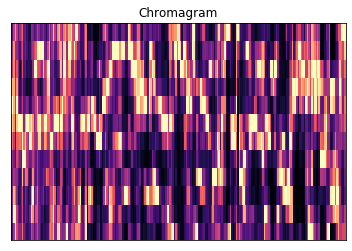

mean 0.41547176
standard deviation 0.29748425


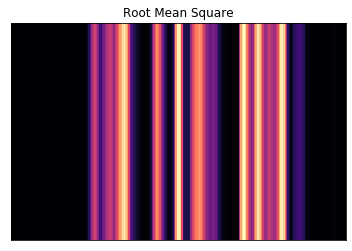

mean 0.04921781
standard deviation 0.056908384


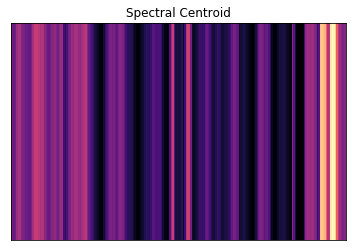

mean 1716.5226324891005
standard deviation 831.6682065660448


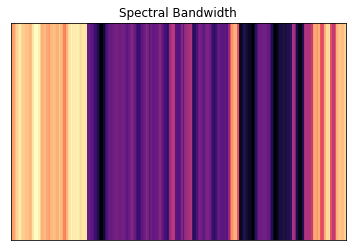

mean 1573.9692546587892
standard deviation 702.5657461799505


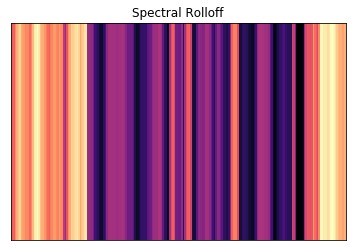

mean 3361.9780553069936
standard deviation 1688.8124031420805


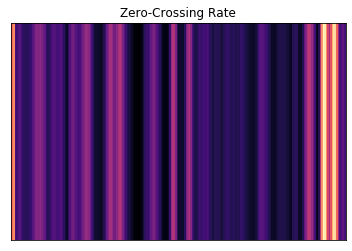

mean 0.09842631470264317
standard deviation 0.059409840180946874


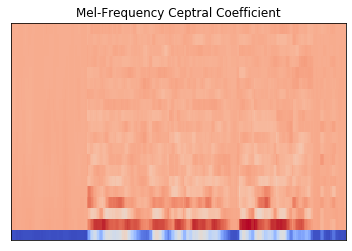

mean -17.076149
standard deviation 99.626816


In [20]:
present_values(df.iloc[1,:])

In [21]:
play_sound(df.iloc[1,:])

DOESN'T WORK


PermissionError: [Errno 13] Permission denied: 'C:\\Users\\Frederik\\AppData\\Local\\Temp\\tmp6f3osnfb.wav'

# Modelling

In [67]:
from matplotlib import pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
plt.style.use('ggplot')

ModuleNotFoundError: No module named 'mathplotlib'

In [54]:
df = pd.read_csv(output_pathname, encoding="utf-8", sep="\t")
df

,up_votes,down_votes,path,age,gender,accent,chroma_stft,rms,spec_cent,spec_bw,rolloff,zcr,mfcc
0,2,0,Datasets/wav_clips/common_voice_en_10091129.wav,fifties,male,us,0.472234,0.024861,2307.869775,2132.580959,4797.588375,0.136395,-24.520874
1,2,0,Datasets/wav_clips/common_voice_en_10091130.wav,fifties,male,us,0.415472,0.049218,1716.522632,1573.969255,3361.978055,0.098426,-17.076149
2,4,0,Datasets/wav_clips/common_voice_en_10563.wav,thirties,other,us,0.497167,0.014763,3081.801988,2350.760264,5792.458357,0.366476,-26.730108
3,4,0,Datasets/wav_clips/common_voice_en_10564.wav,thirties,other,us,0.390783,0.038026,2731.799814,2045.142584,5051.226239,0.216953,-22.359816
4,2,0,Datasets/wav_clips/common_voice_en_10410522.wav,twenties,male,us,0.481844,0.010068,3518.683239,2802.146680,6893.528353,0.217115,-24.592739
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2302,2,0,Datasets/wav_clips/common_voice_en_10209062.wav,fifties,female,us,0.439742,0.033243,2970.832932,2662.461360,6184.766602,0.167612,-22.828602
2303,2,0,Datasets/wav_clips/common_voice_en_10209063.wav,fifties,female,us,0.399398,0.026217,2760.807520,2266.275394,5187.672335,0.177096,-21.018087
2304,2,0,Datasets/wav_clips/common_voice_en_10209065.wav,fifties,female,us,0.388222,0.024172,2230.666062,2299.027168,4676.918096,0.113927,-20.731462
2305,2,0,Datasets/wav_clips/common_voice_en_10209066.wav,fifties,female,us,0.439761,0.021787,2918.167471,2388.274420,5495.593766,0.187932,-19.918543


# Normalized standard deviation

In [156]:
df.mean()/df.std() #Standard deviation compared to mean

up_votes       1.714286
down_votes     0.369948
chroma_stft    7.488636
rms            1.298474
spec_cent      4.092883
spec_bw        5.362939
rolloff        4.008697
zcr            2.839174
mfcc          -3.046343
dtype: float64

# Data Balance

In [157]:
def distribution_plotter(plot_data,feature):
    counts = plot_data[feature].value_counts()
    counts = counts/sum(counts)
    counts.plot(kind="bar")
    plt.title(feature + " distribution")
    plt.show()
    

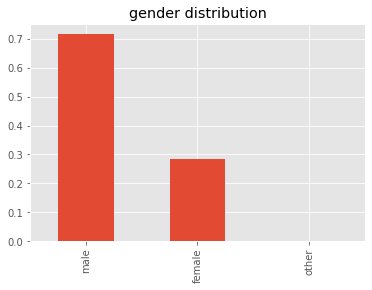

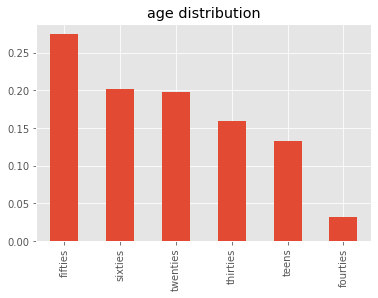

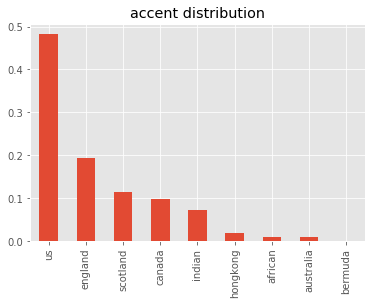

In [158]:
distribution_plotter(df,"gender")
distribution_plotter(df,"age")
distribution_plotter(df,"accent")

### Balancing the Data

In [177]:
minimum_count = 100
data_gender = df.copy()
data_age = df.copy()
data_accent = df.copy()

In [178]:
def dataBalancer(unbalanced_data,feature,floor):
    
    # Removing feature categories that are too small to predict
    counts = unbalanced_data[feature].value_counts()
    for index, value in counts.iteritems():
        if (value < floor):
            unbalanced_data = unbalanced_data[unbalanced_data[feature] != index]
    
    # Taking the largest possible sample of each feature category so that they would be balanced
    counts = unbalanced_data[feature].value_counts()
    lowest_count = min(counts)
    balanced_data = unbalanced_data.copy().head(0)
    for index, value in counts.iteritems():
        index_sample = unbalanced_data[unbalanced_data[feature] == index].sample(lowest_count)
        balanced_data = balanced_data.append(index_sample,ignore_index=True,sort=False)
    
    return balanced_data
    

In [179]:
data_gender = dataBalancer(data_gender,"gender",minimum_count)
data_age = dataBalancer(data_age,"age",minimum_count)
data_accent = dataBalancer(data_accent,"accent",minimum_count)

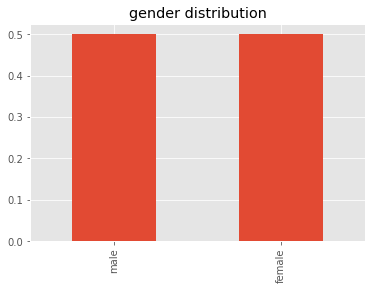

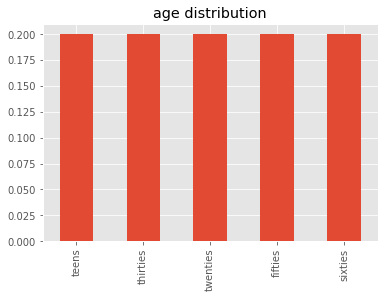

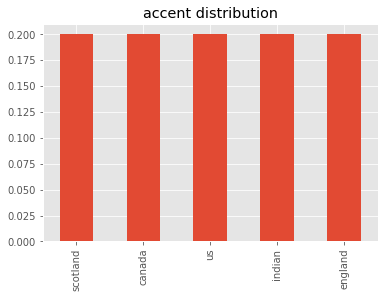

In [182]:
distribution_plotter(data_gender,"gender")
distribution_plotter(data_age,"age")
distribution_plotter(data_accent,"accent")

# Visualization

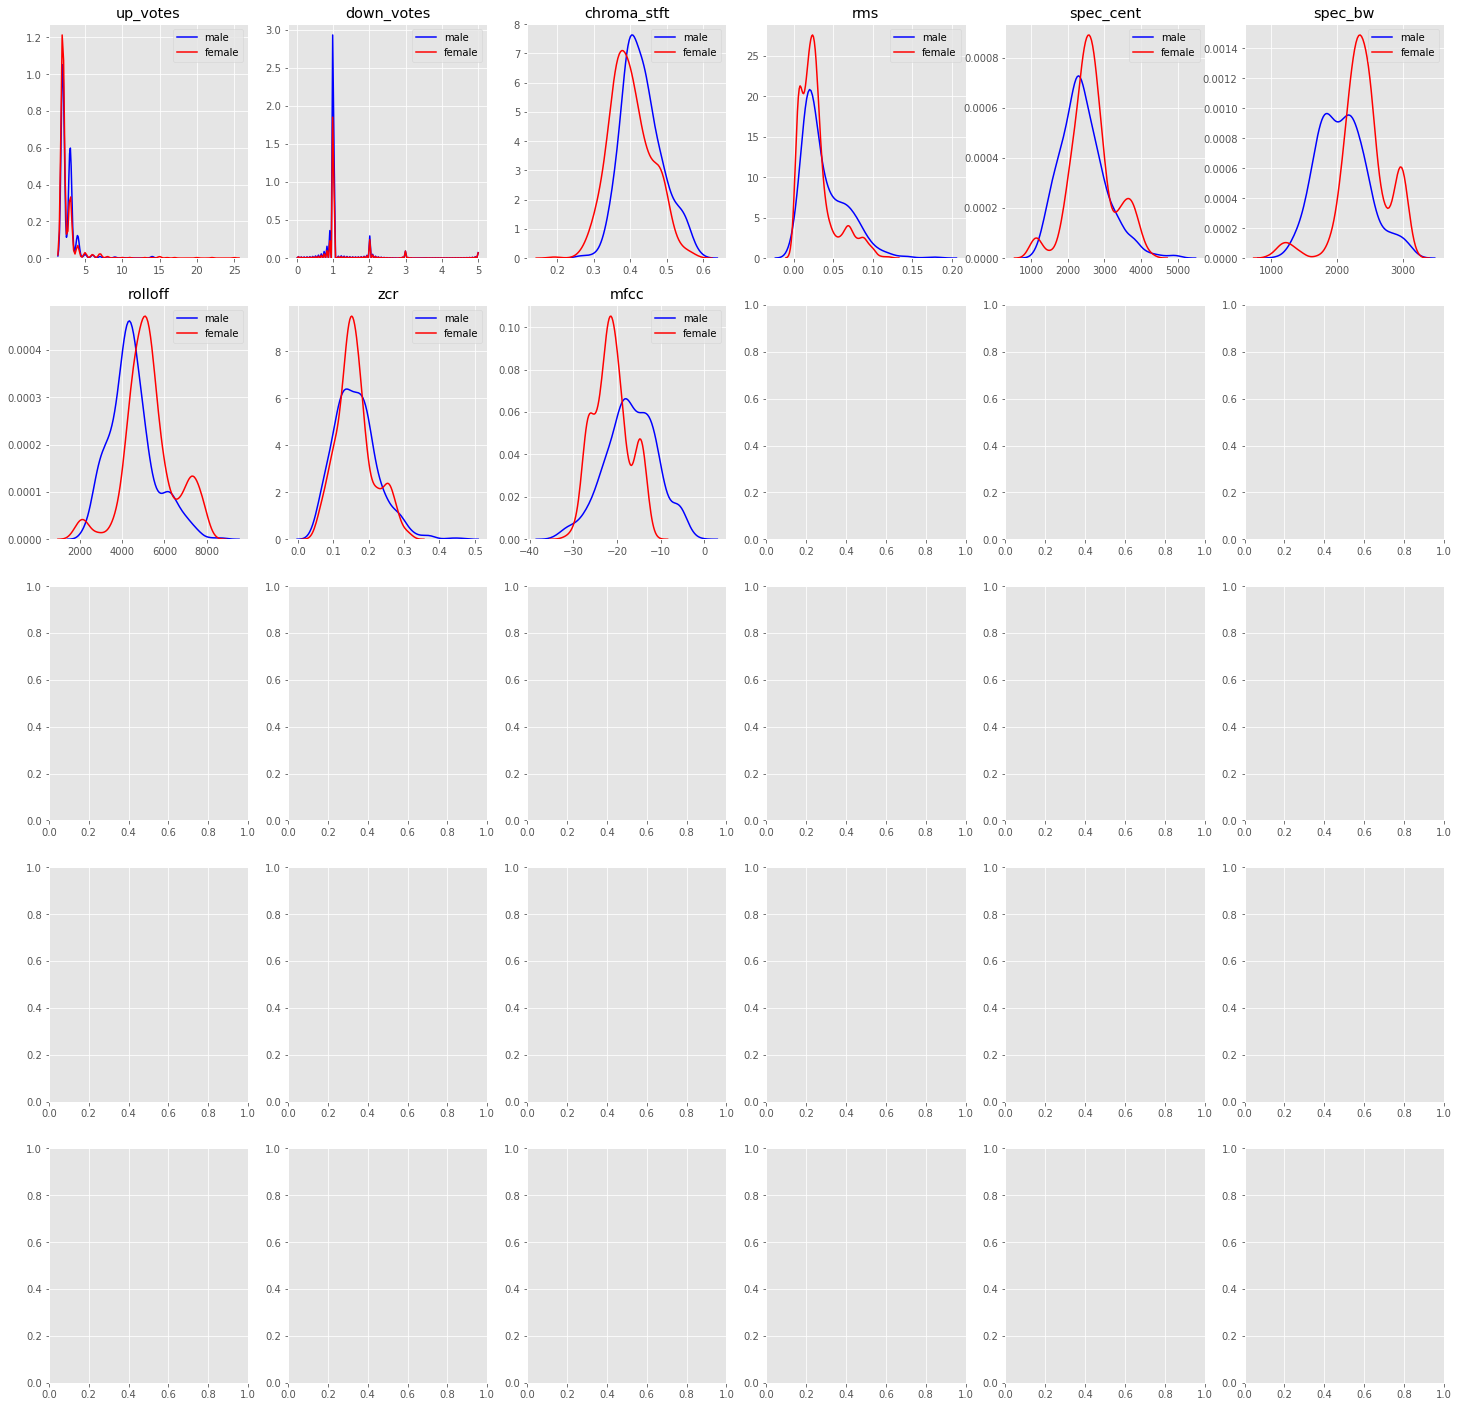

In [201]:
data = data_gender.copy()
data = data.drop(["path"],axis=1)
data = data.drop(["age"],axis=1)
data = data.drop(["accent"],axis=1)
plt.subplots(5,6,figsize=(25,25))
male_subset = data.loc[data["gender"] == "male"]
female_subset = data.loc[data["gender"]=="female"]
data = data.drop(["gender"],axis=1)
i = 1
for column in data.columns:
    plt.subplot(5,6,i)
    plt.title(column)
    sns.kdeplot(male_subset[column],color="blue",label="male")
    sns.kdeplot(female_subset[column],color="red",label="female")
    i += 1
plt.show()

# Creating some models and comparing them

In [192]:
df = data_gender.copy()

In [193]:
X_train, X_test, y_train, y_test = train_test_split(df[["chroma_stft","rms","spec_cent","spec_bw","rolloff","zcr","mfcc"]],df.gender,train_size=0.7)

In [194]:
#Decision tree
dct = DecisionTreeClassifier(criterion='entropy').fit(X_train, y_train)
dct_prediction = dct.predict(X_test)
print("Decision tree accuracy: "+str(accuracy_score(y_test,dct_prediction)))

Decision tree accuracy: 0.8142493638676844


In [195]:
#Random forest
rf = RandomForestClassifier(n_estimators=1000,max_depth=4).fit(X_train, y_train)
rf_prediction = rf.predict(X_test)
print("Random Forest accuracy: "+str(accuracy_score(y_test,rf_prediction)))

Random Forest accuracy: 0.8702290076335878


In [196]:
#SVM linear
svm_linear = SVC(kernel='linear',probability=True).fit(X_train,y_train)
svm_linear_prediction = svm_linear.predict(X_test)
print("SVM linear: "+str(accuracy_score(y_test,svm_linear_prediction)))

SVM linear: 0.7379134860050891


In [197]:
# SVM POLY
#svm_poly = SVC(kernel='poly', degree=2 ,gamma='auto',probability=True).fit(X_train,y_train)
#svm_poly_prediction = svm_poly.predict(X_test)
#print("SVM poly: "+str(accuracy_score(y_test,svm_poly_prediction)))

In [198]:
# SVM RBF
#svm_rbf = SVC(kernel='rbf',gamma='auto',probability=True).fit(X_train,y_train)
#svm_rbf_prediction = svm_rbf.predict(X_test)
#print("SVM RBF: "+str(accuracy_score(y_test,svm_rbf_prediction)))

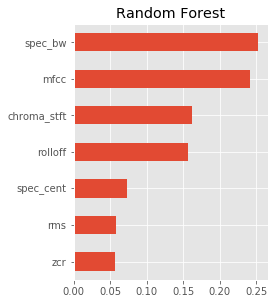

In [199]:
plt.subplots(figsize=(16, 16))
x = np.arange(-5,5,0.25)
y = np.arange(-5,5,0.25)
xx, yy = np.meshgrid(x, y)
df = pd.DataFrame({'x':xx.flatten(),'y':yy.flatten()})


feature_importances_rf = pd.Series(rf.feature_importances_, index= X_train.columns)
plt.subplot(3,4,1)
plt.title('Random Forest')
feature_importances_rf.sort_values().plot(kind='barh')

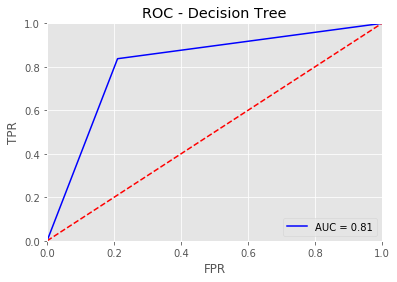

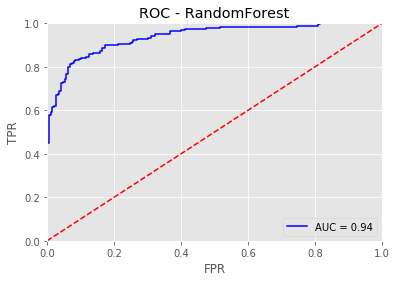

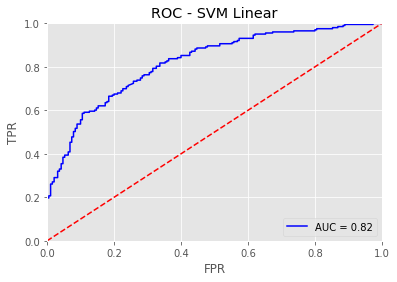

In [200]:
#WORK IN PROGRESS - ROC (https://stackoverflow.com/questions/25009284/how-to-plot-roc-curve-in-python)
val = y_test.to_frame()
probs = dct.predict_proba(X_test)
probs = probs[:,1]
fpr,tpr,thresholds = metrics.roc_curve(val,probs,pos_label="male")
roc_auc = metrics.auc(fpr, tpr)
# ROC PLOT
plt.title('ROC - Decision Tree')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('TPR')
plt.xlabel('FPR')
plt.show()


val = y_test.to_frame()
probs = rf.predict_proba(X_test)
probs = probs[:,1]
fpr,tpr,thresholds = metrics.roc_curve(val,probs,pos_label="male")
roc_auc = metrics.auc(fpr, tpr)
# ROC PLOT
plt.title('ROC - RandomForest')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('TPR')
plt.xlabel('FPR')
plt.show()

val = y_test.to_frame()
probs = svm_linear.predict_proba(X_test)
probs = probs[:,1]
fpr,tpr,thresholds = metrics.roc_curve(val,probs,pos_label="male")
roc_auc = metrics.auc(fpr, tpr)
# ROC PLOT
plt.title('ROC - SVM Linear')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('TPR')
plt.xlabel('FPR')
plt.show()

In [202]:
import tensorflow as tf